# 제 20대 대선 정책 공약 시각화

- __chapter 0. 라이브러리와 경로__
- __chapter 1. 데이터 전처리 클래스__
- __chapter 2. 시각화 클래스__
    - 후보자 정책 공약
    - 후보자 지역 공약
- __chapter 3. 주제 분류 클래스__
    - LSA
    - LDA
- __chapter 4. 클러스터링__
    - 계층 클러스터링
    - 부분 클러스터링
- __chapter 5. 후보추천 모델__
    - 지도학습 모델
    - 비지도학습 모델
    - 코사인 유사도
    
    
- __Reference__

---
__Abstract__
- chapter 2에서 가장 기본적이고 직관적인 접근으로 대선공약집의 공약 순위와 지역별 공약을 시각화했습니다. 그리고 유사도를 통해 각 후보가 어떤 정책을 추진 혹은 폐지할지 키워드를 분석해 보았고, 각 후보 간 단어 사용에 대한 상관관계를 시각화했습니다. 
- chapter 3에서 레이블이 없는 데이터 특성상 공약들이 단어를 통해 주제가 어떻게 묶이는지 분석하기 위해 LSA를 이용해서 주제를 유추하였고, 유추한 레이블을 통해 각 후보의 정책분포를 시각화했습니다.
- chapter 4에서 후보들의 공약을 레이블이 없는 형태 그대로 분석하기 위해 비지도 학습 클러스터링인 K-means를 사용하여 유사한 후보끼리 군집을 나누어 후보 집단을 형성한 결과를 시각화했습니다.
- chapter 5에서 후보 추천은 지도학습과 비지도학습 그리고 유사도 분석 기법을 사용하여 사용자 입력값을 받고 입력값에 가장 적합한 공약집을 추천합니다. 


---

# 프론트 서비스, 외부데이터 및 추가데이터

1. [프론트 서비스](https://share.streamlit.io/trailblazer-yoo/streamlit_promise/promise.py)

2. [추가데이터 및 외부데이터 구글 드라이브](https://drive.google.com/drive/folders/1ieYgc6JB87jDTsgReCHmxvBIOiGQe7nL?usp=sharing)
---

# 0. 라이브러리와 경로

In [1]:
import re
import glob
import pdfplumber
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import font_manager, rc
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import seaborn as sns
from gensim.models.doc2vec import TaggedDocument
import gensim
import umap
import pyLDAvis
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models
from wordcloud import WordCloud
from konlpy.tag import Okt
from nltk import word_tokenize
from collections import Counter
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from scipy.spatial import ConvexHull
from scipy import interpolate
from scipy.cluster import hierarchy as shc
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from tensorflow import random
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import random
from scipy.sparse import issparse 
from numpy.linalg.linalg import norm
from numpy.random import randint
import folium
import json
from folium import plugins
import platform

import warnings
warnings.filterwarnings(action='ignore')

#if platform.system():
#    font_location = 'AppleGothic'
#    font_name = 'AppleGothic'
#elif platform.system() == 'Windows':
#    font_location = 'C:/Windows/Fonts/NanumGothic.ttf'
#    font_name = font_manager.FontProperties(fname=font_location).get_name()   

# font-path example
# 폰트 - 윈도우
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf'
# font_name = font_manager.FontProperties(fname=font_location).get_name()

# 폰트 - 맥
font_location = 'AppleGothic'
font_name = 'AppleGothic'

population_path = '/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/location/korea_population.csv'
jason_path = r'/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/location/korea_province.json'
#image_path = sorted(glob.glob('./image/*'))
plt.rcParams['axes.unicode_minus'] = False
okt = Okt()

# example path
stopwords_path = '/Users/junho/Downloads/stopwords_all(1).txt'
pdf_path = sorted(glob.glob('/Users/junho/Downloads/pdf/*'))
regional_promise_path = glob.glob('/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/pdf_location/*')
mask_path = '/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/mask/mask.png'

/Users/yuseonjong/miniforge3/envs/tf/lib/python3.9/site-packages/numba/cpython/hashing.py:525: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)
/Users/yuseonjong/miniforge3/envs/tf/lib/python3.9/site-packages/yellowbrick/style/colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/Users/yuseonjong/miniforge3/envs/tf/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = Loos

- 편리성과 에러를 방지하기위해 경로를 클래스 외부에서 정의했습니다.

# 1. 데이터 전처리 클래스
- 클래스 설명 
    
    - pdf와 불용어 텍스트파일을 입력받아 앞으로 이용할 전처리내용을 대부분 정의합니다. 
    - 전처리 클래스를 따로 만듦으로서 각 클래스의 실행시간을 단축 시켰습니다.


- 주요 라이브러리 : pdfplumber, re, konlpy

---

In [2]:
class PreprocessData():
    def __init__(self, stopwords_path, pdf_path):
        self.stopwords_path = stopwords_path
        self.pdf_path = pdf_path
        self.pdf_files = [pdfplumber.open(file) for file in self.pdf_path]
        
        f = open(self.stopwords_path, 'r')
        sw = f.readlines()
        f.close()
        self.stopwords = set(word.rstrip('\n') for word in sw)
        
        self.tokens = self.tokenization()
        self.all_tokens = sum(self.tokens, [])
        word_counts = dict(Counter(self.all_tokens))
        self.word_counts_sorted = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        self.word_idx = {self.word_counts_sorted[i][0]: i + 1 for i in range(len(self.word_counts_sorted))}
        
        (top10, top10_token, top140_token) = self.candidates_promise_top10()
        
        self.lines_token = self.lines_token()
        self.top10 = top10
        self.top10_token = top10_token
        self.top140_token = top140_token
        self.tf_sentences = self.tf_sentences()

    def tokenization(self):
        tokens = []
        hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
        for pdf in self.pdf_files:
            temp = []
            for page in pdf.pages:
                page_text = page.extract_text()
                hangul_text = hangul.sub('', page_text)
                hangul_tokens = okt.nouns(hangul_text)
                for hangul_token in hangul_tokens:
                    if hangul_token not in self.stopwords:
                        temp.append(hangul_token)
            tokens.append(temp)
            
        return tokens
    
    def candidates_promise_top10(self):
        top10 = []
        top10_token = []
        top140_token = []
        hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')

        for number, pdf in enumerate(self.pdf_files):
            # top 10
            temp_text = [page.extract_text() for page in pdf.pages]
            temp_text = ''.join(temp_text)
            text_space = []
            temp_token = []
            temp_token_140 = []
            if number != 11 and number != 13:
                for num in range(1,11):
                    premise_text = temp_text[temp_text.find(f'공약순위 {num}')+9 :temp_text.find('\n목', temp_text.find(f'공약순위 {num}'))]
                    if '\n' in premise_text:
                        premise_text = ''.join(premise_text.splitlines())
                    if f'기호 {number + 1}' in premise_text:
                        premise_text = premise_text[:premise_text.find(f'기호 {number + 1}')]
                    text_space.append(premise_text)
                    hangul_line = hangul.sub('', premise_text)
                    tokens = [token for token in okt.nouns(hangul_line) if token not in self.stopwords]
                    if len(tokens) > 0:
                        temp_token.extend(tokens)
                        temp_token_140.append(' '.join(tokens))
            else:
                for num in range(1,11):
                    premise_text = temp_text[temp_text.find(f'공약순위 {num}')+9 :temp_text.find('\n', temp_text.find(f'공약순위 {num}'))]
                    if '\n' in premise_text:
                        premise_text = ''.join(premise_text.splitlines())
                    text_space.append(premise_text)
                    hangul_line = hangul.sub('', premise_text)
                    tokens = [token for token in okt.nouns(hangul_line) if token not in self.stopwords]
                    if len(tokens) > 0:
                        temp_token.extend(tokens)
                        temp_token_140.append(' '.join(tokens))

            top10.append(text_space)
            top10_token.append(' '.join(temp_token))
            top140_token.append(temp_token_140)

        return top10, top10_token, top140_token
    
    def lines_token(self, drop_len=5):
        lines_token = []
        hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')

        for pdf in self.pdf_files:
            temp = []
            for i in range(len(pdf.pages)):
                for line in pdf.pages[i].extract_text().split('\n'):
                    hangul_lines = hangul.sub('', str(line).strip())
                    if len(str(hangul_lines)) > drop_len:
                        tokens = [token for token in okt.nouns(hangul_lines) if token not in self.stopwords]
                        if len(tokens) > 0:
                            temp.append(tokens)
            lines_token.append(temp)
        return lines_token
    
    # tf_sentences 수정
    def get_candidate_page_data(self,num):
        path = self.pdf_path[num-1]
        pdf = pdfplumber.open(path)
        temp = [page.extract_text() for page in pdf.pages]
        return temp
    
    def tf_sentences(self):
        sentences = []
        for i in range(1, 15):
            target = self.get_candidate_page_data(i)
            temp = []
            for i in target:
                temp.extend(i.split('\n'))
            hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
            temp = [hangul.sub('', i).strip() for i in temp]
            temp_sen = ''

            for i in temp:
                if len(i) > 5:
                    temp_sen += i
            sentences.append(okt.nouns(temp_sen))

        tf_sentences = []
        for token_set in sentences:
            temp = ' '.join(token_set)
            tf_sentences.append(temp)
            
        return tf_sentences
    
pre = PreprocessData(stopwords_path, pdf_path)
pre_user = PreprocessData(stopwords_path, pdf_path)
print('Preprocessing class load.')

Preprocessing class load.


- 전처리 클래스에서 중요한 전처리 데이터는 init에 담아 뒀습니다. 다음은 실행확인을 위한 샘플 입니다.

    pre = PreprocessData(stopword_path, pdf_path) : 불용어와 pdf를 입력받습니다.
    pre.stopwords_path
    pre.stopwords
    pre.pdf_path
    pre.pdf_files
    pre.tokens : 각 후보자 공약집 토큰입니다.
    pre.all_tokens : 전체 후보자 공약집 토큰입니다.
    pre.word_idx : 전체 후보자 공약집의 단어 수 기반 단어집입니다.
    pre.lines_token : 각 후보자 공약집의 줄단위 토큰입니다. 
    pre.top10 : 각 후보자의 공약순위 데이터입니다.
    pre.top10_token 
    pre.top140_token
    pre.tf_sentences : 각 후보자의 전체공약 토큰입니다.




# 2. 시각화 클래스

- 클래스 설명

    - 단어 수로 접근하여 기본적인 단어 수 그래프와 워드 클라우드를 시각화하였고, 각 후보자의 추진/폐지할 정책이 무엇인지 유사도를 통해 키워드 분석했습니다. 
    - __LSA__ 와 __Clustering__ 을 적용해볼 수 있게 해주고 저희에게 인사이트를 주었던 자료를 시각화했습니다. 

    - 외부 데이터를 이용하여 후보의 지역 정책을 시각화했습니다.
    
    
- 주요 라이브러리 : pandas, matplotlib, WordCloud, seaborn, folium, gensim
---

In [3]:
class VisualizeKeywords():
    def __init__(self, mask_path, font_location, font_name):
        self.mask_path = mask_path
        self.font_location = font_location
        self.font_name = font_name
        
        sns.set_style('whitegrid')
        rc('font', family=self.font_name)
        
    def show_graphs(self, text_counts, sents_clear=None, num=None):
        tags = text_counts.most_common(100)
    
        mask = np.array(Image.open(self.mask_path))
        
        wc = WordCloud(font_path=self.font_location, background_color='white', 
                  colormap='twilight_shifted', max_font_size=100, mask=mask)
        
        cloud = wc.generate_from_frequencies(dict(tags))
    
        plt.figure(figsize=(25, 13))
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    
        plt.subplot(2, 2, 1)
        if not num:
            plt.title(f'정책 공약 키워드', size=20)
        else:
            plt.title(f'기호 {num}번의 정책 공약 키워드', size=27)
        plt.axis('off')
        plt.imshow(cloud)

        tags20 = dict(text_counts.most_common(20))
    
        plt.subplot(2, 2, 2)
        plt.xlabel('주요 단어')
        plt.ylabel('빈도')
    
        tags20_df = pd.DataFrame(tags20.values(), index=tags20.keys(), columns=['빈도'])
        
        if not num:
            plt.title(f'정책 공약 키워드 top 20', size=20)
        else:
            plt.title(f'기호 {num}번의 정책 공약 키워드 top 20', size=20)
            plt.suptitle(f'기호 {num}번', size=40, va='bottom')
        
        sns.set_palette(reversed(sns.color_palette('Purples', 20)), 20)
        
        ax1 = sns.barplot(x=tags20_df.index, y=tags20_df['빈도'], data=tags20_df)
        for bar in ax1.patches:
            bar.set_width(0.5)
        
        plt.xticks(rotation='45')    
        
        if sents_clear:
            keys = ['추진', '폐지']
            model = Word2Vec(sents_clear, min_count=4, seed=65)
    
            for i in range(len(keys)):
                try:
                    df = pd.DataFrame(model.wv.most_similar(keys[i]))
                    df.set_index(0)
                except:
                    print(f"기호 {num}번의 정책 공약에 '{keys[i]}'이/가 존재하지 않습니다.")
                    plt.subplot(2, 2, i + 3)
                    if not num:
                        plt.title(f"단어 유사도: {keys[i]}", size=20)
                    else:
                        plt.title(f"기호 {num}번의 단어 유사도: {keys[i]}", size=20)
                else:
                    plt.subplot(2, 2, i + 3)
                    ax2 = sns.barplot(y=df[0], x=df[1])
                    
                    for bar in ax2.patches:
                        bar.set_height(0.5)
                        
                    plt.xlabel('유사도')
                    plt.ylabel('단어')
                    if not num:
                        plt.title(f"단어 유사도: {keys[i]}", size=20)
                    else:
                        plt.title(f"기호 {num}번의 단어 유사도: {keys[i]}", size=20)
        plt.show()
                
    def stacked_category(self):
        temp = []
        for i in range(4):
            key = {'경제': 0, '복지': 0, '정치': 0, '보건': 0, '환경': 0, '문화': 0,
                   '관광': 0, '노동': 0, '교육': 0, '산업': 0, '안보': 0, '국방': 0,
                   '북한': 0}
            for j in pre.tokens[i]:
                if j in key:
                    key[j] += 1
                    
            temp.append(key)
        df = pd.DataFrame(temp)
        df.index = ['기호1','기호2','기호3','기호4']
        df = df.transpose()

        df_per = df.copy()
        for i in range(len(df_per.index)):
            df_per.loc[df_per.index[i]] /= sum(df_per.loc[df_per.index[i]]) 
    
        df_per = round(df_per, 3)
        
        fig = plt.figure(figsize=(30, 8))
        colors = ['royalblue', 'crimson', 'gold', 'sandybrown']

        ax1 = fig.add_subplot(1, 2, 1)
        df.plot(kind='bar',stacked=True, color=colors, ax=ax1)
        plt.xticks(rotation='45')
        plt.legend(frameon=True, shadow=True)
        plt.title('후보자별 키워드 등장 횟수', fontsize=20)

        ax2 = fig.add_subplot(1, 2, 2)
        df_per.plot(kind='bar', stacked=True, color=colors, ax=ax2)
        plt.xticks(rotation='45')
        plt.title('후보자별 키워드 등장 비율', fontsize=20)
        plt.legend().remove()

        i = 0
        j = 0
        for p in ax2.patches:
            if i >= len(df.index):
                i = 0
                j += 1
            left, bottom, width, height = p.get_bbox().bounds
            if height == 0:
                i += 1
                continue
            ax2.annotate("%d%%"%(df_per[df.columns[j]][i]*100), xy=(left+width/2, bottom+height/2), ha='center', va='center')
            i += 1
    
        plt.show()

    def corr_map(self, max_features=500):  # max features = 1000 등 높은값 에러 이슈 rename하지 않은코드는 정상작동
        cv = CountVectorizer(max_features=max_features)
        tdm = cv.fit_transform(pre.tf_sentences)
        df = pd.DataFrame(data=tdm.toarray(), columns=cv.get_feature_names_out(), index=list(range(1, 15)))
        df = df.transpose()

        sns.clustermap(df.corr(),
                       annot=True,
                       cmap='RdYlBu_r',
                       vmin=-1, vmax=1,
                       figsize=(12, 10))
        
vk = VisualizeKeywords(mask_path, font_location, font_name)
print('VisualizeKeywords class load.')

VisualizeKeywords class load.


## 2.1 show_graph
- show_graph 에서는 비중이 큰 후보1,2,3,4번의 공약집에 대한 그래프를 작성했습니다. 4개의 subplot 으로 구성이 되어 있습니다. 
- 각 후보 그래프의 위쪽 두 개의 그래프는 단어 수 기반으로 작성되었습니다.
- 아래쪽 두 개의 그래프는 word2vec을 이용했고, 각 후보가 추진 혹은 폐지하고 싶은 정책, 공약이 무엇인지 키워드의 유사도를 이용해 유추해 보았습니다.


- 각 유사도에 대해 적절한 키워드를 대분류를 이용해서 1,2번 후보만 언급해 보면 다음과 같습니다.
- 후보자 1번은 추진에 대한 단어 유사도에서 주거,주택,코로나,교육,청년이 있고, 폐지에 대한 단어 유사도는 없습니다.
- 후보자 2번은 추진에 대한 단어 유사도에서 고용,수도권,법이 있고, 폐지에 대한 단어 유사도에서는 주택,기업,투자,개발이 있습니다.
___

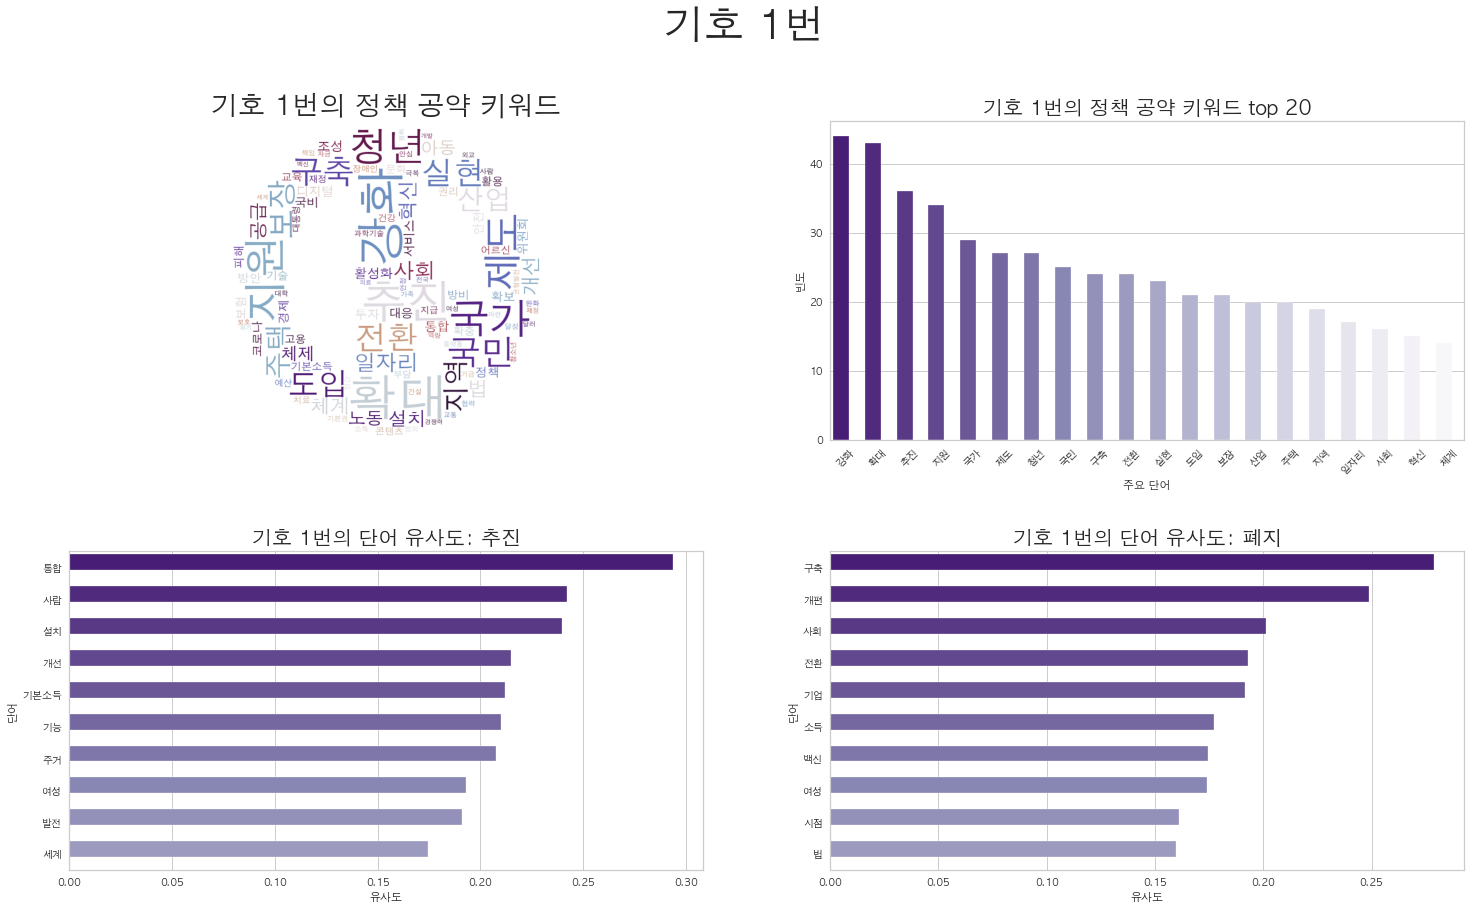

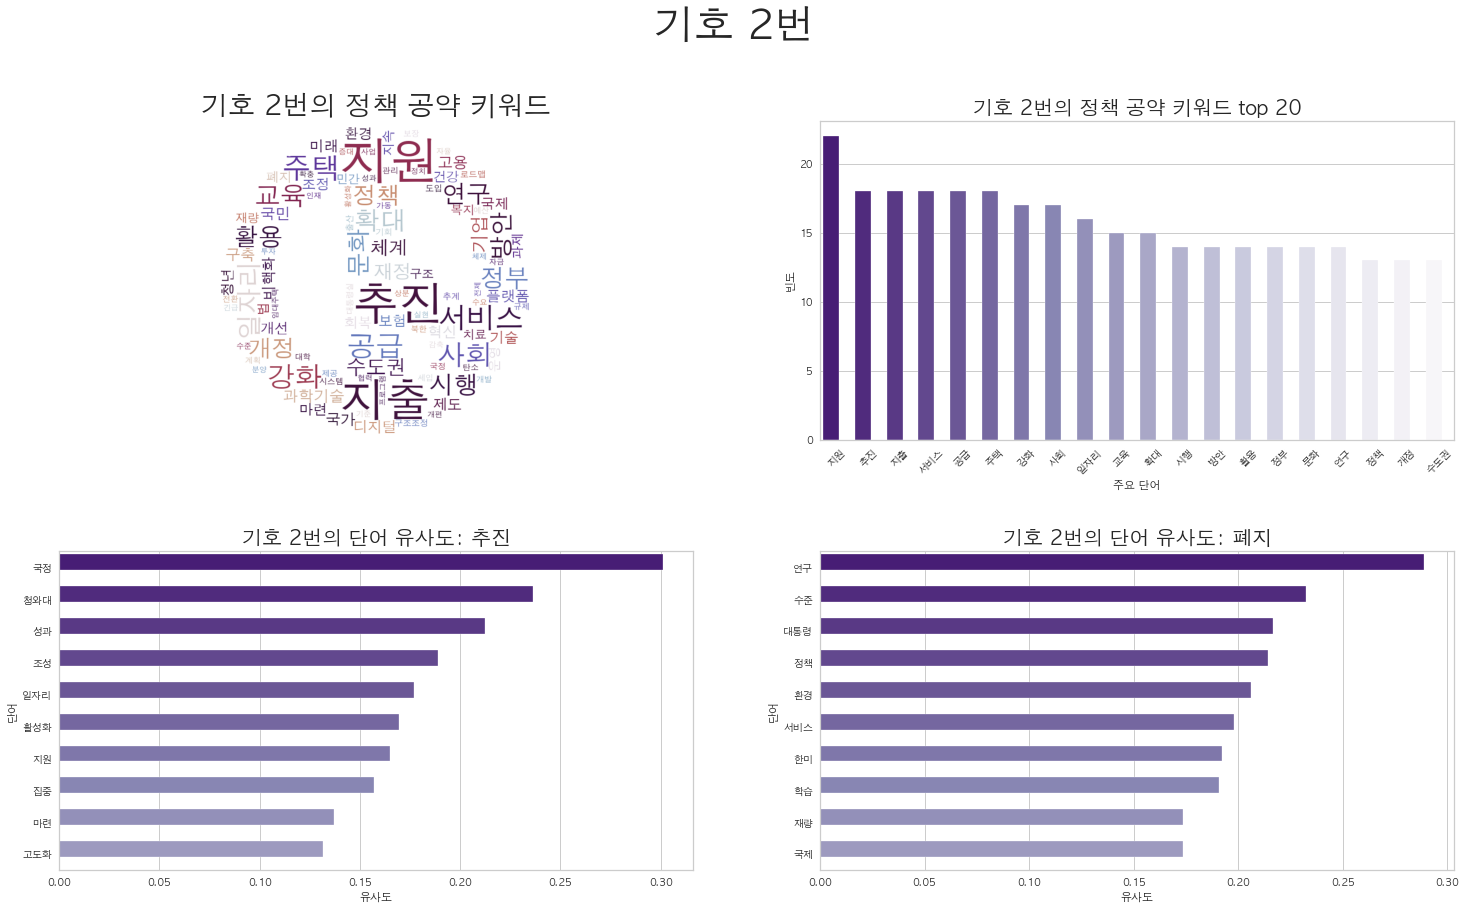

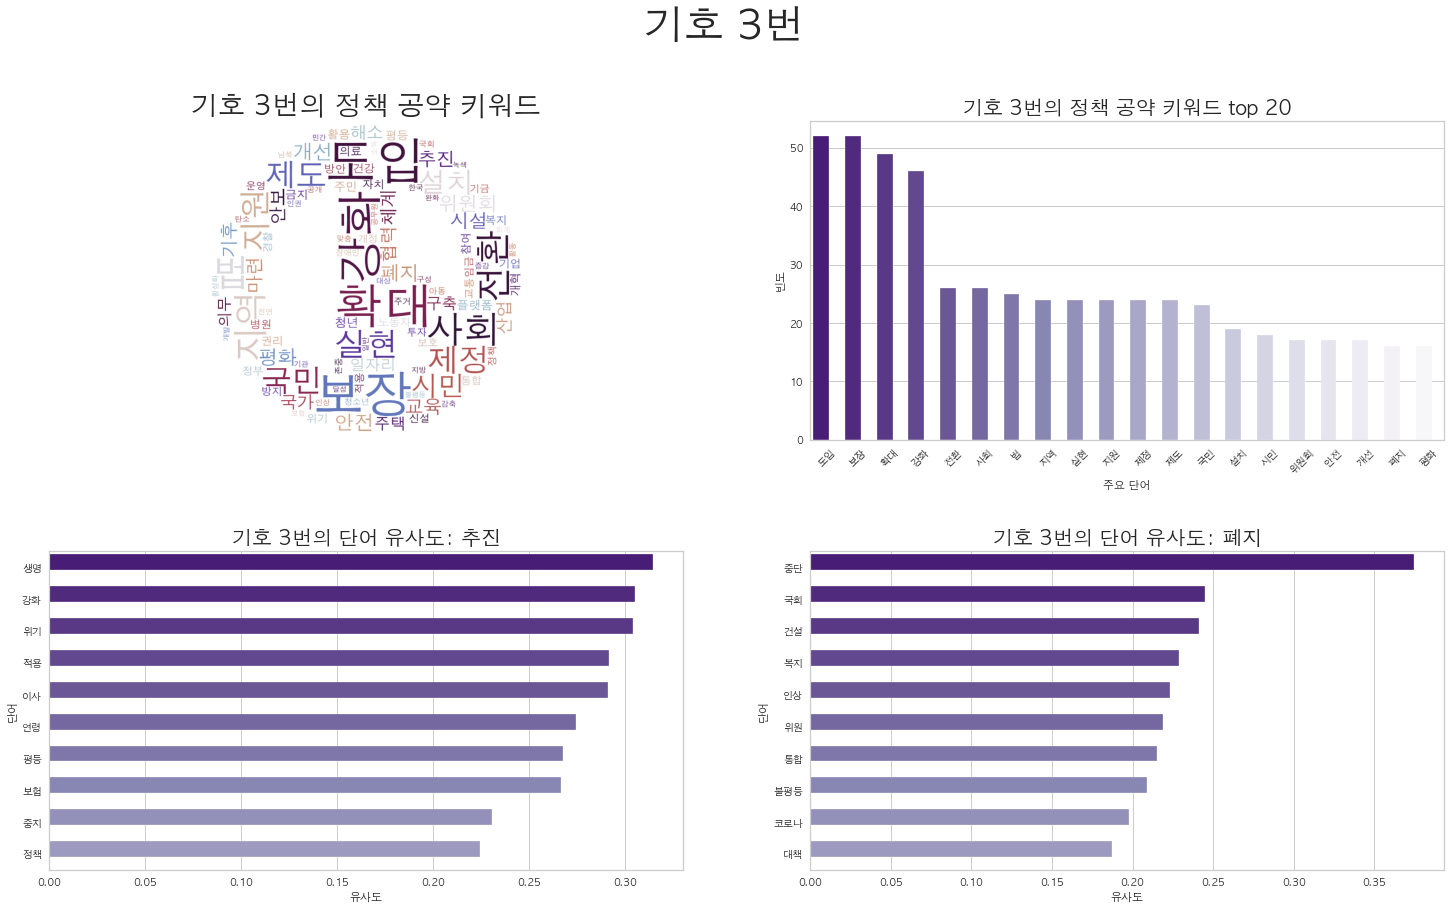

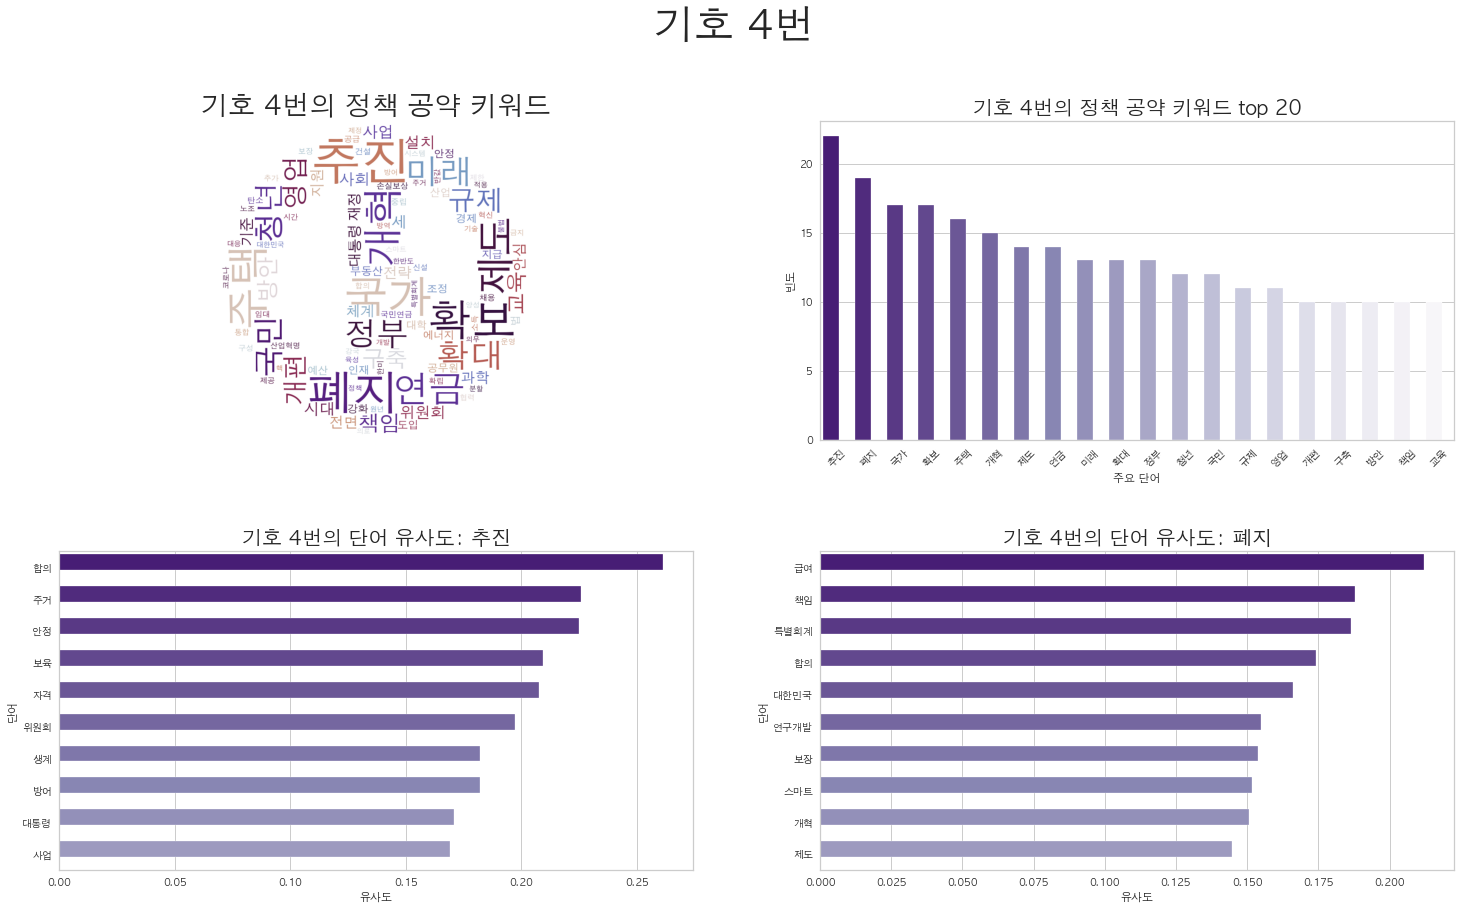

In [4]:
num_of_candidate = 4
for i in range(num_of_candidate):
    counts = Counter(pre.tokens[i])
    vk.show_graphs(counts, pre.lines_token[i], i + 1) 

- 다음은 전체 후보자 공약집에 대한 count 기반 키워드 입니다.

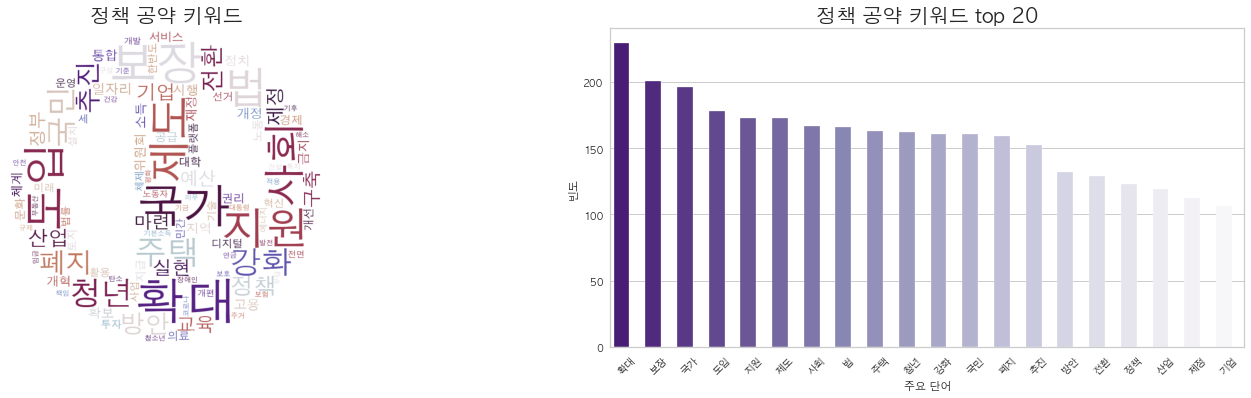

In [5]:
counts_for_all = Counter(pre.all_tokens)

vk.show_graphs(counts_for_all)

## 2.2. 키워드 분류
- 키워드를 선정한 뒤, 각 후보자의 정책 공약에 얼마나 사용되었는지 비교해 보았습니다.
- 그래프는 기호 1, 2, 3, 4번 후보자들의 키워드 누적 사용 횟수와 비율을 보여줍니다.
- 그래프를 통해 각 후보자가 어떤 키워드에 중점을 두고 있는지 유추해볼 수 있습니다.
- 각 후보가 원하는 정책 분야가 있다고 판단이 되었고, chapter3에서 주제분석을 진행했습니다.
___

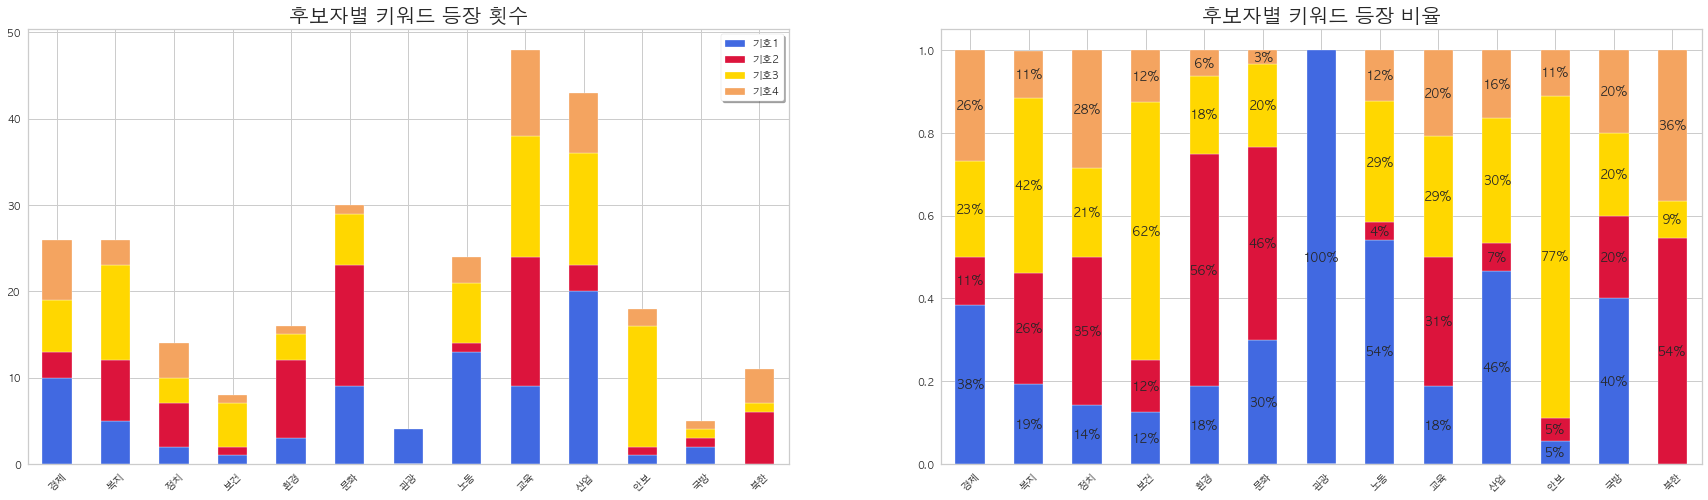

In [6]:
vk.stacked_category() 

## 2.3 corr_map

- 각 후보자 공약집 전체에 대해서 count 기반 상위 500단어에 대한 상관계수와 그에 대한 덴드로그램 입니다.
- 단어 맵핑에대한 상관관계이므로 값이클수록 같은 단어의 사용횟수의 차이가 작습니다.
- 대각선을 제외한 가장 높은 상관계수는 1,3번후보의 값이고 1번후보의 상관계수는 전체적으로 높습니다.
- 계층적 클러스터링에서 특징적인 두 개의 그룹이 드러납니다. [2,4,9,13],[1,3,7,12]
- 후보 간 공약집의 유사한 정도를 알아볼 수 있었고, chapter4에서 비계층적 클러스터링을 진행했습니다.
___

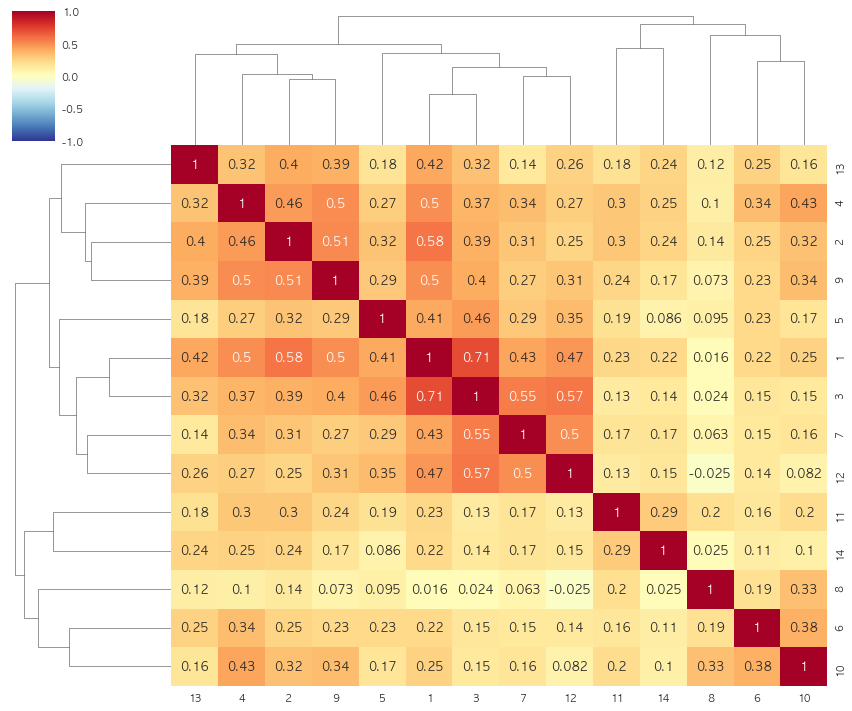

In [7]:
vk.corr_map(max_features=500)

# 2.4. 지역 공약 시각화
- 기호 1, 2, 3번 후보자들의 지역 공약 자료집을 활용하여 시각화해 보았습니다.
- 사용자가 후보자들의 지역 공약을 비교할 수 있도록 제작했습니다.
- 지역 공약 자료집을 활용하여 지역별로 핵심 공약을 분류한 다음, 지도 위에 표현해 보았습니다.
- 지역별 인구수를 나타냄으로써 해당 지역의 유권자 수 차이를 확인할 수 있습니다.
- 파란색/빨간색/노란색의 마커를 클릭하면 각 후보자의 공약을 담고 있는 팝업이 나타납니다.
- 오른쪽 위의 버튼을 통해 원하는 후보자를 선택할 수 있습니다.
___

In [8]:
class GetLocalPromise():
    def __init__(self, population_path, jason_path, regional_promise_path):
        self.province = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시',
                         '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원도',
                         '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도',
                         '제주특별자치도']
        
        self.df_loc = pd.DataFrame([[37.5657, 126.9769],[36.4802, 127.2892],[37.4561, 126.7059],[36.3505, 127.3848],
                                    [35.8714, 128.6014],[35.5374, 129.3105],[35.1800, 129.0768],[35.1589, 126.8546],
                                    [37.2747, 127.0096],[37.8854, 127.7298],[36.5184, 126.8000],[36.8000, 127.7000],
                                    [36.5760, 128.5056],[35.2383, 128.6924],[35.8198, 127.1081],[34.8162, 126.4629],[33.4996, 126.5312]],
                                    index = ['서울특별시','세종특별시','인천광역시','대전광역시',
                                             '대구광역시','울산광역시','부산광역시','광주광역시',
                                             '경기도','강원도','충청남도','충청북도',
                                             '경상북도','경상남도','전라북도','전라남도','제주특별자치도'],
                                    columns = ['위도', '경도'])
        
        self.population_path = population_path
        self.jason_path = jason_path
        self.files = regional_promise_path
        
        self.promise_no1 = self.promise_no1(self.files[0])
        self.promise_no2 = self.promise_no2(self.files[1])
        self.promise_no3 = self.promise_no3(self.files[2])
        
    def two_columns_pdf(self, file):    
        x0 = 0    
        x1 = 0.5  
        y0 = 0  
        y1 = 1  

        all_content = []
        with pdfplumber.open(file) as pdf:
            for i, page in enumerate(pdf.pages):
                width = page.width
                height = page.height

                left_bbox = (x0*float(width), y0*float(height), x1*float(width), y1*float(height))
                page_crop = page.crop(bbox=left_bbox)
                left_text = page_crop.extract_text()

                left_bbox = (0.5*float(width), y0*float(height), 1*float(width), y1*float(height))
                page_crop = page.crop(bbox=left_bbox)
                right_text = page_crop.extract_text()
                page_context = '\n'.join([left_text, right_text])
                all_content.append(page_context)
                
        return all_content
    
    def promise_no1(self, file_name):
        file_name = file_name
        texts = self.two_columns_pdf(file_name)
        
        ans = []
        for doc in texts:
            loc = []
            for sen in re.split('[0-1]\d\d\d',doc):
                loc.append(sen.replace('\n    ', '').lstrip('\n'))
            ans.append(loc)
            
        promises = []
        for i in ans:
            temp = []
            for j in i:
                temp.append(j.split('\n')[0].strip().split('•')[0])
            promise = '<ol start="1"><br><li>' + '<br><br><li>'.join(temp[1:])
            promises.append(promise)
            
        df = pd.DataFrame(promises, index=self.province, columns=['공약'])
        df['지역'] = '<h3>' + df.index + '</h3>'
        df = pd.merge(df, self.df_loc, left_on=df.index, right_on=self.df_loc.index)
        
        return df
    
    def promise_no2(self, file_name):
        pdf = pdfplumber.open(file_name)
        
        promises = []
        for page in pdf.pages:
            lines = page.extract_text().split('\n')
            for line in lines:
                if line[0] != '■':
                    temp = []
                else:
                    temp.append(line[2:])
                    if len(temp) == 7:
                        promise = '<ol start="1"><br><li>' + '<br><br><li>'.join(temp)
                        promises.append(promise)
                        
        df = pd.DataFrame(promises, index=self.province, columns=['공약'])
        df['지역'] = '<h3>' + df.index + '</h3>'
        df = pd.merge(df, self.df_loc, left_on=df.index, right_on=self.df_loc.index)
    
        return df
                        
    def promise_no3(self, file_name):
        file_name = file_name
        texts = self.two_columns_pdf(file_name)
        
        ans = []
        for doc in texts:
            loc = []
            for sen in re.split('\d\.',doc):
                loc.append(sen)
            ans.append(loc)
        
        promises = []
        for i in ans:
            temp = []
            for j in i:
                temp.append(j.split('\n')[0].lstrip())
            promise = '<ol start="1"><br><li>' + '<br><br><li>'.join(temp[1:])
            promises.append(promise)
            
        df = pd.DataFrame(promises, index=self.province, columns=['공약'])
        df['지역'] = '<h3>' + df.index + '</h3>'
        df = pd.merge(df, self.df_loc, left_on=df.index, right_on=self.df_loc.index)
        
        return df
    
    def promise_map(self):
        with open(self.jason_path, mode='rt', encoding='utf-8') as f:
            geo_data = json.loads(f.read())
        f.close()
    
        file_path = self.population_path
        df_p = pd.read_csv(file_path)  
        df_p.columns = ['지역', '인구']
        
        korea_map = folium.Map(location=[35.8714, 127.6014],tiles='cartodbpositron',width=800,height=750, zoom_start = 7, max_bounds = True,
                               zoom_control = False, scrollWheelZoom=False, dragging=True,
                               min_lat = 32, max_lat = 43, min_lon =123, max_lon = 133)

        korea_map.add_child(folium.GeoJson(geo_data, control = False))

        folium.Choropleth(
                          geo_data=geo_data,
                          data=df_p,
                          columns=('지역', '인구'),
                          key_on='feature.properties.CTP_KOR_NM',
                          fill_color='YlOrRd',
                          legend_name='인구수',
                          control = False
                          ).add_to(korea_map)


        fg = folium.FeatureGroup(name='후보전체', control = False)
        korea_map.add_child(fg)

        g1 = plugins.FeatureGroupSubGroup(fg, '이재명')
        korea_map.add_child(g1)
        g2 = plugins.FeatureGroupSubGroup(fg, '윤석열', show = False)
        korea_map.add_child(g2)
        g3 = plugins.FeatureGroupSubGroup(fg, '심상정', show = False)
        korea_map.add_child(g3)

        df_list = [self.promise_no1, self.promise_no2, self.promise_no3]
        g_list = [g1, g2, g3]
        loc_adjustments = [-0.05, 0, 0.03]
        colors = ['blue', 'red', 'beige']
        
        for i in range(0, 3):
            df = df_list[i]
            g = g_list[i]
            loc_adj = loc_adjustments[i]
            color = colors[i]
            for province, promise, lat, lng in zip(df.지역, df.공약, df.위도, df.경도):
                iframe = folium.IFrame(province + promise)
                popup = folium.Popup(iframe, min_width=600, max_width=1000)
                folium.Marker([lat + loc_adj,lng + loc_adj], popup=popup, icon=folium.Icon(color=color, icon='info-sign')).add_to(g)       

        folium.LayerControl(collapsed=False).add_to(korea_map)

        return korea_map
    
gp = GetLocalPromise(population_path, jason_path, regional_promise_path)
print('GetLocalPromise Load')

GetLocalPromise Load


In [9]:
gp.promise_map()

# 3. 주제 분류 클래스
- 클래스설명

    - 2.2. 키워드 분류를 통해 후보자들의 정책 공약에 등장하는 키워드들이 특정 주제들로 분류될 수 있음을 확인하였습니다. 
    - 따라서, LSA를 활용하여 후보자들의 정책 공약을 임의의 주제별로 분류할 수 있는지 시도해 보았습니다.


- 주요 라이브러리 : TfidfVectorizer, TruncatedSVD, Pipeline
---

In [10]:
class CategorizePromise():
    def __init__(self, font_name):
        self.font_name = font_name
        
        sns.set_style('whitegrid')
        rc('font', family=self.font_name)
        
        self.df = self.promise_reshaped()
        self.df_tokens = self.promise_tokenized()
        (self.tfidf_vectorizer, self.svd_model) = self.model_for_categorize()
        self.df_result = self.show_categorized_result()
       
    def promise_reshaped(self):
        df_array = np.array(pre.top10).reshape(140, 1)
        df_reshaped = pd.DataFrame(df_array, columns=['정책 공약'])
        df_reshaped['기호'] = [f'기호 {index // 10 + 1}번' for index in df_reshaped.index]
        
        return df_reshaped
    
    def promise_tokenized(self):
        tokens = []
        for text in self.df.values.tolist():
            text = okt.nouns(str(text))
            token = ' '.join(word for word in text if word in pre.word_idx)
            tokens.append(token)

        df_reshaped_tokens = pd.DataFrame(tokens, columns=['정책 공약_tokens'])
        
        return df_reshaped_tokens
        
    def model_for_categorize(self):
        tfidf_vectorizer = TfidfVectorizer()
        X_tfidf = tfidf_vectorizer.fit_transform(self.df_tokens['정책 공약_tokens'])
        
        svd_model = TruncatedSVD(n_components=6, algorithm='randomized', n_iter=3, random_state=1)
        svd_model.fit(X_tfidf)
        
        return tfidf_vectorizer, svd_model
    
    def get_topics(self):
        components = self.svd_model.components_
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        for idx, topic in enumerate(components):
            print(f'Topic {idx + 1}:', [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-6: -1]])
            
    def show_categorized_result(self):
        pipe = Pipeline([('tfidf', self.tfidf_vectorizer), ('svd_model', self.svd_model)])
        
        self.df['주제_idx'] = 0
        self.df['주제'] = 0 
        self.df['관련성'] = 0
        
        topics = ['평등/권리보장', '정치/행정/교육', '부동산', '국방/통일/외교', ' 경제/환경/기술', '미래/청년']
        
        for idx in self.df_tokens.index:
            t = pipe.transform([self.df_tokens['정책 공약_tokens'].iloc[idx]])
            self.df['주제_idx'].iloc[idx] = np.argmax(t) + 1
            self.df['주제'].iloc[idx] = topics[np.argmax(t)]
            self.df['관련성'].iloc[idx] = f'{np.max(t)*100:.3f}%'
    
        return self.df
    
    def show_graphs_all(self):
        plt.figure(figsize=(20, 8))
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)
        
        sns.set_palette('Set2', 6)

        df = self.df_result
        plt.suptitle(f'전체 정책 공약 분류', fontsize=40, va='bottom')
            
        plt.subplot(1, 2, 1)
        ax = sns.countplot(x=df['주제'])
        for bar in ax.patches:
            bar.set_width(0.5)
        
        plt.subplot(1, 2, 2)
        df_groupby = df.groupby('주제').count()
        
        colors = ['mediumaquamarine', 'yellowgreen', 'gold', 'lightsteelblue', 'plum', 'darksalmon']

        plt.pie(df_groupby['주제_idx'], 
                autopct='%.1f%%',
                colors=colors, 
                wedgeprops=dict(width=0.6))
        plt.legend(labels=df_groupby.index, loc='upper right')
        plt.show()
        
    def show_pie_chart_selective(self, num):
        plt.figure(figsize=(20, 80))

        for i in range(num):
            df = self.df_result[i*10: (i+1)*10]
            df_groupby = df.groupby('주제').count()
        
            plt.subplot(7, 2, i+1)
            plt.pie(df_groupby['주제_idx'],
                    autopct='%.1f%%',
                    wedgeprops=dict(width=0.6))
            plt.legend(labels=df_groupby.index)
            plt.title(f'기호 {i + 1}번', size=20)
        plt.show()
        
    def show_stacked_plot_selective(self, num):
        df_selective = self.df_result[:num*10]
        
        df = pd.crosstab(df_selective['주제'], df_selective['기호'])
        
        df_per = df.copy()
        
        for i in range(len(df_per.index)):
            df_per.loc[df_per.index[i]] /= sum(df_per.loc[df_per.index[i]]) 
    
        df_per = round(df_per, 3)
        
        colors = ['royalblue', 'crimson', 'gold', 'sandybrown', 'green', 'firebrick', 'red', 
                  'olivedrab', 'cadetblue', 'yellowgreen', 'forestgreen', 'tomato', 'darkseagreen', 'steelblue']
        
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(1, 1, 1)
        
        df.plot(kind='bar', stacked=True, color=colors, ax=ax)
        plt.xticks(rotation='0')
        plt.legend(frameon=True, shadow=True, loc=0)

        i = 0
        j = 0
        for p in ax.patches:
            if i > 5:
                i = 0
                j += 1
            left, bottom, width, height = p.get_bbox().bounds
            if height == 0:
                i += 1
                continue
            ax.annotate("%.1f%%"%(df_per[df.columns[j]][i]*100), xy=(left+width/2, bottom+height/2), ha='center', va='center')
            i += 1
    
        plt.show()
               
cp = CategorizePromise(font_name)
print('CategorizePromise class load.')

CategorizePromise class load.


## 3.1. LSA
- __LSA__는 특잇값 분해(SVD)를 활용하여 문서에 __숨어 있는 주제__를 찾아내는 기법입니다.
- 주제는 주제별 키워드를 확인한 다음, 평등/안정, 정치/행정/교육, 부동산, 국방/통일/외교, /경제/환경/기술, 미래/청년으로 설정하였습니다.
- 각 정책 공약과 가장 관련성이 높은 주제를 할당하였습니다.
- 여기서 __관련성__은 각 정책 공약이 어떤 잠재 의미군(주제)에 속하는 용어들을 많이 포함하고 있는지, 그 비중을 의미합니다.
- 정책 공약의 공약 순위만 사용하였습니다. 따라서, 정책 공약의 상세 내용이 반영되지 않아 결과가 예상과 다를 수 있습니다.
---

In [11]:
cp.get_topics()

Topic 1: [('사회', 0.37562), ('개혁', 0.32097), ('청년', 0.298), ('보장', 0.27899), ('평등', 0.25353)]
Topic 2: [('개혁', 0.63347), ('정치', 0.20116), ('제도', 0.18916), ('선거', 0.18616), ('교육', 0.16013)]
Topic 3: [('주택', 0.60935), ('공급', 0.24272), ('민간', 0.19338), ('실현', 0.17756), ('한반도', 0.16873)]
Topic 4: [('한반도', 0.50208), ('평화', 0.46786), ('시대', 0.1987), ('외교', 0.18387), ('안보', 0.15473)]
Topic 5: [('혁신', 0.27985), ('국가', 0.20644), ('실현', 0.18937), ('정책', 0.18319), ('경제', 0.16451)]
Topic 6: [('미래', 0.36735), ('청년', 0.34155), ('교육', 0.20412), ('일자리', 0.15126), ('복지', 0.14112)]


In [12]:
# topics = ['평등/권리보장', '정치/행정/교육', '부동산', '국방/통일/외교', ' 경제/환경/기술', '미래/청년']
cp.show_categorized_result().sort_values(['주제_idx', '기호'])

,정책 공약,기호,주제_idx,주제,관련성
90,한•미•일 군사동맹강화와 한•일 핵무기 공동개발,기호 10번,1,평등/권리보장,1.931%
91,공영방송 폐지와 빅테크 언론검열 금지,기호 10번,1,평등/권리보장,5.908%
94,대학의 완전 자유화 보장과 사학재단 자율 정리,기호 10번,1,평등/권리보장,11.510%
98,5•18 역사왜곡처벌법(5•18민주화운동특별법) 폐지와 5•18유공자 공개,기호 10번,1,평등/권리보장,5.606%
100,적폐 청산 및 악법 폐지,기호 11번,1,평등/권리보장,6.546%
...,...,...,...,...,...
32,"공적연금 통합하여 청년의 미래, 대한민국의 미래를 지키겠습니다",기호 4번,6,미래/청년,45.999%
35,부모찬스 수시 폐지하고 학제개편으로 창의적 미래교육 하겠습니다,기호 4번,6,미래/청년,25.382%
61,"1,000만 국가책임일자리로 완전 고용",기호 7번,6,미래/청년,10.872%
85,G10 대한민국 만들기,기호 9번,6,미래/청년,9.399%


### 3.1.1. LSA 결과 시각화 (1)
- __LSA__에 따른 주제 분류 결과를 countplot과 piechart를 활용하여 시각화하였습니다.
- 후보자들의 정책 공약에서 각 주제가 차지하는 비중을 살펴볼 수 있습니다.
- 시각화는 상위 후보 4명에 한해서 진행하였습니다.
- 각 후보가 가장 지향하는 정책분야가 무엇인지 유추할 수 있게 됩니다.
---

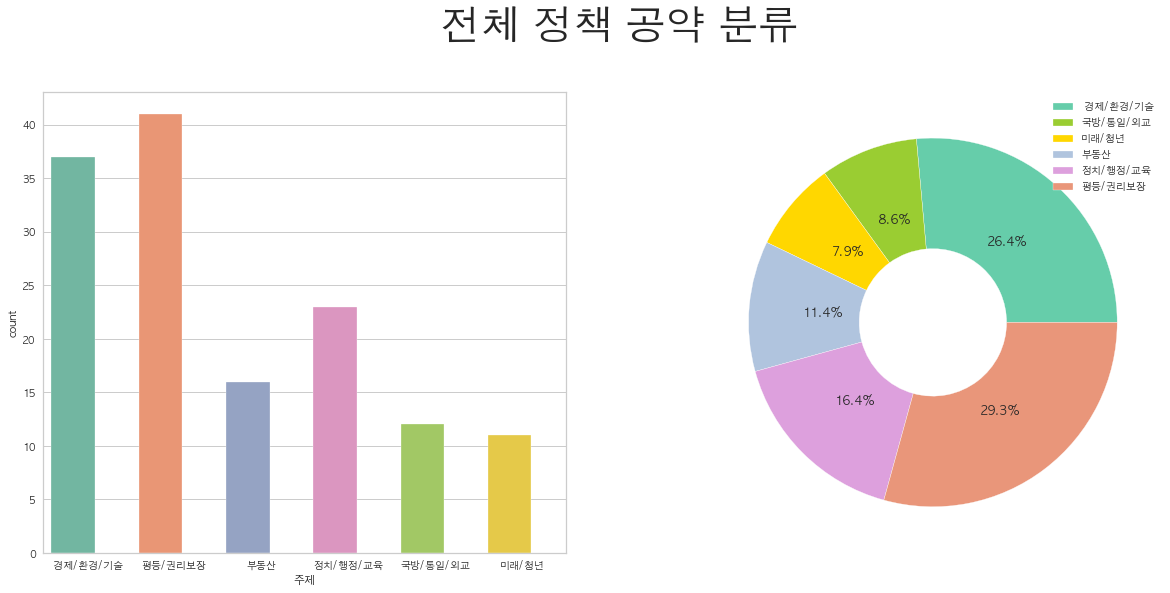

In [13]:
cp.show_graphs_all()

In [14]:
number_of_candidates = int(input('검색할 후보자의 범위를 입력하세요 (상위 n명): '))

검색할 후보자의 범위를 입력하세요 (상위 n명): 4


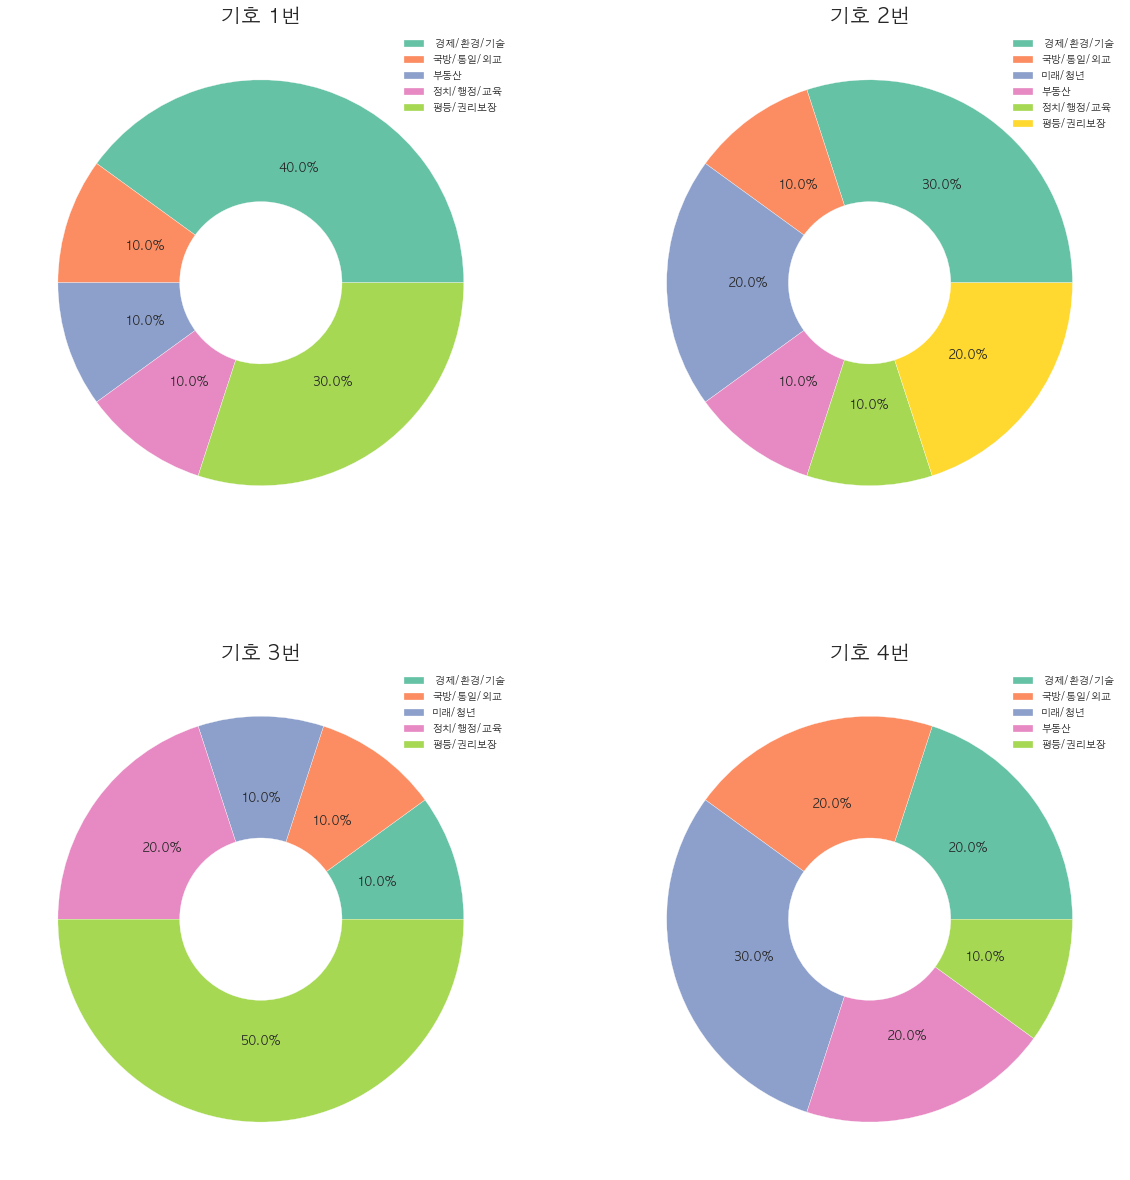

In [15]:
cp.show_pie_chart_selective(number_of_candidates)

### 3.1.2. LSA 결과 시각화 (2)
- 주제 분류 결과를 누적 그래프로 표현해 보았습니다.
- 주제별로 각 후보자가 어떤 정책 공약에 중점을 두고 있는지 한눈에 비교할 수 있습니다.
- 위와 마찬가지로 주요 정당 4곳에 한해서 진행하였습니다.

- 시각화 결과, 후보자들의 정책 공약 중 경제/환경/기술과 평등/권리보장이 전반적으로 높은 비중을 차지합니다.
- __후보자__별로 살펴보면, 기호 1번과 기호 2번은 경제/환경/기술, 기호 3번은 평등/권리보장, 기호 4번은 미래/청년 주제를 가장 많이 다루고 있습니다
- __주제__별로 살펴보면, 경제/환경/기술은 기호 1번이, 평등/권리보장과 정치/행정/교육은 기호 3번이, 부동산, 국방/통일/외교와 미래/청년은 기호 4번의 비중이 가장 높습니다.
---

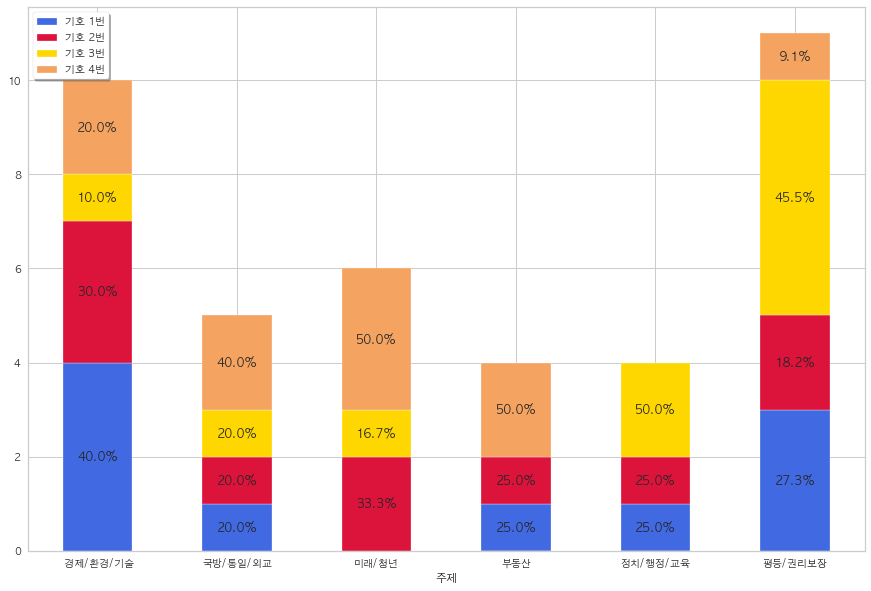

In [16]:
cp.show_stacked_plot_selective(number_of_candidates)

## 3.2 LDA 시각화
- __LDA__ 는 LSA와 비슷하지만 다른점은 주제들이 디리클레 분포(Dirichlet distribution)를 따른다고 가정하여 주제를 분석하는 기법입니다.
- 구체적인 인터페이스 설명은 다음과 같습니다. 
    - 왼쪽 그래프는 후보의 공약을 LDA를 적용하여 주제에 따라 분류한 것을 시각화한 결과입니다.
    - 오른쪽 막대 그래프는 각 군집에 따라 특징적인 단어와 빈도수를 나타냅니다.
    - 오른쪽 위의 __λ__ 값이 0에 가까울수록 그 군집만의 특징적인 단어가 나타나고, 1에 가까울수록 전체 공약집에서 가장 많은 빈도수를 차지한 단어가 해당 군집에서 차지하는 정도를 나타냅니다.
    - 왼쪽 위에 숫자를 입력하면 해당 군집에 대한 정보를 보여줍니다. LDA를 이용한 사후 분석 결과 최적의 군집 개수는 __7__ 개이며, 각 군집에 대한 주제는 topics에 입력하였습니다.
- 주요 라이브러리 : pyLDAvis, gensim
---

In [17]:
lines_token = pre.lines_token

clean_text = [list(' '.join(line) for line in candidate_document) for candidate_document in lines_token]
processed_text = sum(lines_token,[])
dictionary = gensim.corpora.Dictionary(processed_text)
dictionary.filter_extremes(no_below=3, no_above=0.05)
corpus = [dictionary.doc2bow(text) for text in processed_text]

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=7, passes=30, random_state=42) 
lda_visualization = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False) 
pyLDAvis.display(lda_visualization)

# topics = ['평화/안보', '고용/일자리', '주택/부동산', '선거', '법률/제도', '사회보장서비스', '산업']

/Users/yuseonjong/miniforge3/envs/tf/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yuseonjong/miniforge3/envs/tf/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yuseonjong/miniforge3/envs/tf/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yuseonjong/miniforge3/envs/tf/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/yuseonjong/miniforge3/envs/tf

# 4. 클러스터링
- 클래스설명

    - 클래스에는 크게 데이터 전처리 함수, k 평균 군집 평가 함수, 시각화 함수 3가지로 나눌 수 있습니다.
    - 데이터 전처리 함수는 BOW를 위한 Vectorize와 Doc2Vec으로 구성되어 있습니다.
    - k 평균 군집 평가 함수는 실루엣 계수 및 시각화, 엘보우 방법으로 구성되어 있습니다.
    - 시각화 함수에는 덴드로그램, pca기반 k 평균 시각화, umap기반 k 평균 시각화로 구성되어 있습니다.

- 주요 라이브러리 : sklearn, yellowbrick, umap, gensim, matplotlib, seaborn
--- 

In [18]:
class Kmeans_Visualization:
    def __init__(self, top10_token,image_path, n = 5):
        self.n = n
        
        self.top10_token = top10_token
        self.image_path = image_path
        
        self.new_df = self.df_vectorize(self.top10_token)
        (pca, pca_df) = self.pca()
        self.pca = pca
        self.pca_df = pca_df
        
        self.x = self.Doc2Vec(self.top10_token)
        (kmeans_labels, clusterable_embedding) = self.umap()
        self.kmeans_labels = kmeans_labels
        self.clusterable_embedding = clusterable_embedding.astype('float64')

        self.x1 = [50, 60, -30, 60, -40, -60, 50, 30, -60, 60,
                -60, 60, -60, 75]
        self.y1 = [-60, 60, 70, -50, 70, 60, 80, -70, -30, -20,
                -60, 70, 10, 55]
        self.x2 = [50, 50, 70, -60, -70, -40, 40, -70, 0, 0,
                -70, 70, 0, -75]
        self.y2 = [-60, 70, 0, 0, 0, -60, 60, 60, -70, 90,
                70, 0, -70, -60]
        
    def show_dendrogram(self):
        data = self.pca_df
        
        plt.figure(figsize=(15, 10))
        plt.suptitle('Dendrogram', fontsize=20)
        
        shc.set_link_color_palette(['r', 'g'])
        
        plt.subplot(1, 2, 1)
        plt.axhline(y=7, ls='--', c='k')

        dend = shc.dendrogram(shc.linkage(data, method='ward'), 
                              labels=data.index + 1,
                              color_threshold=5)
    
        plt.subplot(1, 2, 2)
        plt.axhline(y=7, ls='--', c='k')
        dend = shc.dendrogram(shc.linkage(data, method='ward'),
                              truncate_mode='level',
                              p=2,
                              labels=data.index + 1,
                              color_threshold=0)
        plt.show()
    
    def df_vectorize(self, df):
        vectorize = CountVectorizer()
        x = vectorize.fit_transform(df)
        new_df = pd.DataFrame(x.toarray(), columns=vectorize.get_feature_names_out())
        
        return new_df
    
    def pca(self):
        pc = PCA(n_components=2)
        pca = pc.fit_transform(self.new_df)
        pca_df = pd.DataFrame(data=pca, columns=['x', 'y'])
        
        return pca, pca_df
    
    def Doc2Vec(self, top10_token):
        train_documents_top10 = [TaggedDocument(words=list(text.split(' ')), tags=[i]) for i, text in enumerate(top10_token)]
        model_top10 = gensim.models.doc2vec.Doc2Vec(train_documents_top10, vector_size=100, min_count=1, window = 5, seed = 10)
        model_top10.build_vocab(train_documents_top10)
        model_top10.train(train_documents_top10, total_examples=model_top10.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)
        x = model_top10.dv.vectors
        
        return x
    
    def umap(self):
        clusterable_embedding = umap.UMAP(
            n_neighbors=30,
            min_dist=0.0,
            n_components=2,
            random_state=10,
        ).fit_transform(self.x)

        kmeans_scale = KMeans(init='k-means++', n_clusters=self.n, n_init=10, random_state = 10)
        kmeans_scale.fit(clusterable_embedding)
        kmeans_labels = kmeans_scale.labels_
        
        return kmeans_labels, clusterable_embedding
    
    def sil_score(self, df):
        range_n_clusters = range(2, 14)

        for n_clusters in range_n_clusters:
            clusterer = KMeans(n_clusters=n_clusters)
            preds = clusterer.fit_predict(df)

            score = silhouette_score(df, preds)
            score = np.round(float(score), 4)
            print(f'n_clusters={n_clusters}, sihouette score={score}')
    
    def silhouette_visualizer(self, df):
        fig, ax = plt.subplots(3, 2, figsize=(15, 15))

        for i in range(2, 8):
            km = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=10)
            q, mod = divmod(i, 2)

            visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod]).fit(df)
            visualizer.finalize()
            ax[q-1][mod].set_title(f'n_clusters={i}')
            ax[q-1][mod].xaxis.set_visible(False)

        visualizer.show()
        
    def kelbow_visualizer(self, df):
        km = KMeans(random_state=10)
        visualizer = KElbowVisualizer(km, k=(2, 14))

        visualizer.fit(df)
        visualizer.show()
        
    def PCA_show(self):
        kmeans = KMeans(n_clusters= self.n, n_init = 10, max_iter = 100, random_state = 10).fit(self.pca_df)
        
        fig = plt.figure(figsize = (12, 12), facecolor = 'ghostwhite')
        ax = fig.add_subplot()
        ax.axis("off")
        
        km = KMeans(init='k-means++', n_clusters=self.n, n_init=10, random_state = 10).fit(self.pca)

        h = 0.01

        x_min, x_max = self.pca[:, 0].min() - 1, self.pca[:, 0].max() + 1
        y_min, y_max = self.pca[:, 1].min() - 1, self.pca[:, 1].max() + 1
        x_vals, y_vals = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        output = km.predict(np.c_[x_vals.ravel(), y_vals.ravel()])
        output = output.reshape(x_vals.shape)
        
        plt.imshow(output, interpolation='nearest', extent=(x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()),
        cmap='Pastel2', aspect='auto', origin='lower')
        plt.scatter(
        km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
        s=1000, marker='X',
        c='#6667AB', edgecolor='white',
        alpha=0.7,
        label='centroids'
        )
            
        if self.n == 3:
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 0,0],
                        self.pca_df.iloc[kmeans.labels_ == 0,1], s = 150, c = 'dodgerblue', label = 'Clustering 1')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 1,0],
                        self.pca_df.iloc[kmeans.labels_ == 1,1], s = 150, c = 'red', label = 'Clustering 2')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 2,0],
                        self.pca_df.iloc[kmeans.labels_ == 2,1], s = 150, c = 'darkviolet', label = 'Clustering 3')
            colors = ['dodgerblue', 'red', 'dodgerblue', 'dodgerblue']
        elif self.n == 4:
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 0,0],
                        self.pca_df.iloc[kmeans.labels_ == 0,1], s = 150, c = 'red', label = 'Clustering 1')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 1,0],
                        self.pca_df.iloc[kmeans.labels_ == 1,1], s = 150, c = 'blue', label = 'Clustering 2')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 2,0],
                        self.pca_df.iloc[kmeans.labels_ == 2,1], s = 150, c = 'darkviolet', label = 'Clustering 3')        
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 3,0],
                        self.pca_df.iloc[kmeans.labels_ == 3,1], s = 150, c = 'dodgerblue', label = 'Clustering 4')
            colors = ['red', 'blue', 'dodgerblue', 'dodgerblue']
        elif self.n == 5:
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 0,0],
                        self.pca_df.iloc[kmeans.labels_ == 0,1], s = 150, c = 'darkviolet', label = 'Clustering 1')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 1,0],
                        self.pca_df.iloc[kmeans.labels_ == 1,1], s = 150, c = 'blue', label = 'Clustering 2')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 2,0],
                        self.pca_df.iloc[kmeans.labels_ == 2,1], s = 150, c = 'dodgerblue', label = 'Clustering 3')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 3,0],
                        self.pca_df.iloc[kmeans.labels_ == 3,1], s = 150, c = 'red', label = 'Clustering 4')
            plt.scatter(self.pca_df.iloc[kmeans.labels_ == 4,0],
                        self.pca_df.iloc[kmeans.labels_ == 4,1], s = 150, c = 'springgreen', label = 'Clustering 5')
            colors = ['darkviolet', 'blue', 'dodgerblue', 'red']
        plt.legend(prop={'size': 20})
        
        labels = set(kmeans.labels_)
        sorted_labels = sorted(list(labels))
        
        for i in range(len(self.top10_token)):
            if i == 14:
                print(f'USER의 관심사를 포함하는 후보군은 그룹 {kmeans.labels_[i+1]} 입니다.')
                plt.annotate('USER', (self.pca_df['x'][i] - 0.3, self.pca_df['y'][i] - 0.3), fontsize=20, color = 'red')
            else:plt.annotate(i + 1, (self.pca_df['x'][i] - 0.3, self.pca_df['y'][i] - 0.3), fontsize=14)
        
        
        ax1 = fig.add_subplot()
        for i, path in enumerate(self.image_path):
            img = mpimg.imread(path)
            imagebox = OffsetImage(img, zoom = 0.33)
            ab = AnnotationBbox(imagebox, (self.pca_df['x'][i], self.pca_df['y'][i]), frameon = True, xybox=(self.x1[i], self.y1[i]),
                                xycoords='data', boxcoords="offset points",
                                arrowprops=dict(arrowstyle="->"))
            ax.add_artist(ab)
            ax.set_zorder(2)
            
        plt.title('Promise 10', fontdict = {'fontsize' : 40})
        plt.tight_layout()
        plt.show()
        
    def UMAP_show(self):
        fig = plt.figure(figsize = (12, 12), facecolor = 'ghostwhite')
        ax = fig.add_subplot()
        ax.axis("off")
        km = KMeans(init='k-means++', n_clusters=self.n, n_init=10, random_state = 10).fit(self.clusterable_embedding)

        h = 0.01

        x_min, x_max = self.clusterable_embedding[:, 0].min() - 1, self.clusterable_embedding[:, 0].max() + 1
        y_min, y_max = self.clusterable_embedding[:, 1].min() - 1, self.clusterable_embedding[:, 1].max() + 1
        x_vals, y_vals = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        output = km.predict(np.c_[x_vals.ravel(), y_vals.ravel()])
        output = output.reshape(x_vals.shape)
        
        plt.imshow(output, interpolation='nearest', extent=(x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()),
        cmap='Pastel2', aspect='auto', origin='lower')
        plt.scatter(
        km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
        s=1000, marker='X',
        c='#6667AB', edgecolor='white',
        alpha=0.7,
        label='centroids'
        )
        candidate = (np.where(self.kmeans_labels == self.kmeans_labels[-1])[0] + 1).astype('str').tolist()
        candidate = ','.join(candidate[:len(candidate)-1])
        sns.scatterplot(self.clusterable_embedding[:, 0], self.clusterable_embedding[:, 1],hue=self.kmeans_labels, palette='gist_rainbow', s=300, alpha=0.6).set_title('Cluster UMAP', fontsize=15)

        for i in range(len(self.top10_token)):
            if i == 14:
                print(f'USER의 관심사를 포함하는 후보군은 후보 {candidate}이 포함된 그룹 {self.kmeans_labels[i]} 입니다.')
                plt.annotate('USER', (self.clusterable_embedding[i,0], self.clusterable_embedding[i,1]), fontsize=20, color = 'red')
            else:plt.annotate(i + 1, (self.clusterable_embedding[i,0], self.clusterable_embedding[i,1]), fontsize=14)
        if len(self.top10_token) == 14:
            ax1 = fig.add_subplot()
            ax1.axis("off")
            for i, path in enumerate(self.image_path):
                img = mpimg.imread(path)
                imagebox = OffsetImage(img, zoom = 0.33)
                ab = AnnotationBbox(imagebox, (self.clusterable_embedding[i, 0], self.clusterable_embedding[i, 1]), frameon = True, xybox=(self.x2[i], self.y2[i]),
                                    xycoords='data', boxcoords="offset points",
                                    arrowprops=dict(arrowstyle="->"))
                ax.add_artist(ab)
                ax.set_zorder(2)
        
        plt.show()

class User_Kmeans(Kmeans_Visualization):
    def __init__(self, top10_token, image_path, n = 5):
        self.n = n
        self.top10_token = top10_token
        self.image_path = image_path
        user_input = input()
        user_input_token = okt.nouns(user_input)
        if len(self.top10_token) < 15:
            self.top10_token.append(' '.join(user_input_token))
            self.top10_token_user = self.top10_token
        else:
            self.top10_token.pop()
            raise ValueError('이미 유저 입력값을 입력하여 삭제했습니다. 다시 입력 부탁드립니다.')
        
        self.x = self.Doc2Vec(self.top10_token)
        (kmeans_labels, clusterable_embedding) = self.umap()
        self.kmeans_labels = kmeans_labels
        self.clusterable_embedding = clusterable_embedding.astype('float64')
        
    def change_userinput(self):
        self.top10_token_user.pop()
        user_input = input()
        user_input_token = okt.nouns(user_input)
        if len(self.top10_token) < 15:
            self.top10_token.append(' '.join(user_input_token))
            self.top10_token_user = self.top10_token
        else: raise ValueError('유저 입력값이 2개 이상입니다.')
        
        self.x = self.Doc2Vec(self.top10_token_user)
        (kmeans_labels, clusterable_embedding) = self.umap()
        self.kmeans_labels = kmeans_labels
        self.clusterable_embedding = clusterable_embedding.astype('float64')

top10_token = pre.top10_token
group_num = 4
km = Kmeans_Visualization(top10_token, image_path, n = group_num)
km1 = Kmeans_Visualization(top10_token, image_path, n = group_num)
print('K-means class load.')

K-means class load.


## 4.1 계층 클러스터링
- 군집의 개수를 계층을 만들어서 군집을 분류하는 방법을 계층적 클러스터링이라 합니다.
- __scipy__ 를 이용했고, 덴드로그램을 그래프 위에 임의의 점선을 그어 4개의 클러스터로 구분해보았습니다.
- 입력 데이터는 공약 제목을 pca로 차원 축소한 값이고, 와드연결법을 이용한 덴드로그램 입니다.
- 그 결과, 후보자들의 정책 공약은 [1], [2, 3, 5, 7, 12], [4, 8, 9, 10, 11, 13, 14], [6]으로 구분할 수 있습니다.
___

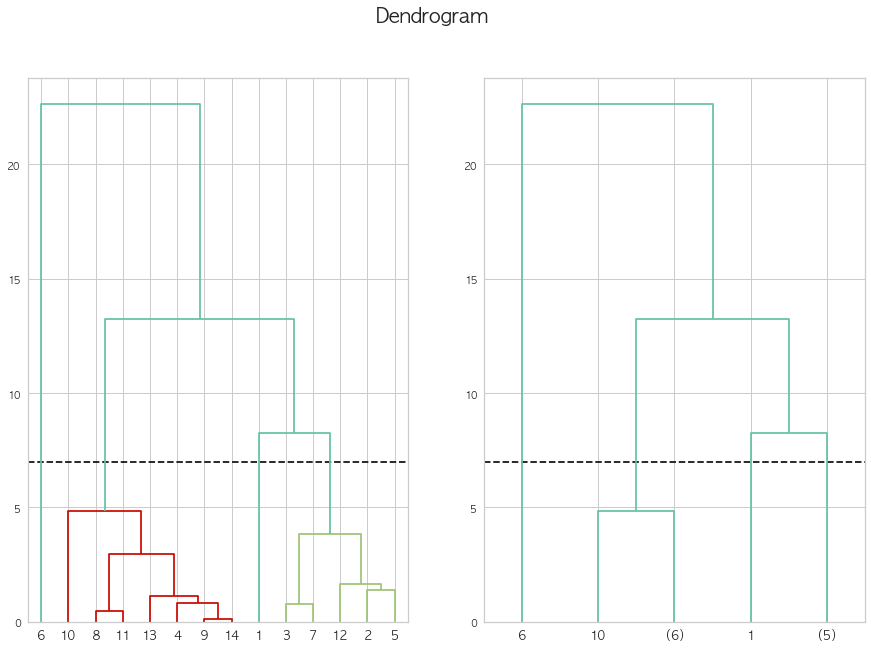

In [19]:
km.show_dendrogram()

## 4.2 부분 클러스터링
- 군집의 개수를 임의로 정하여 군집을 분류하는 것을 비계층적 클러스터링이라 합니다. 대표적으로 K-평균 군집이 있습니다.
___

### 4.2.1. K 평균의 군집 갯수 평가 지표(PCA)
- K-평균 군집화는 __분석자가 정한 군집 개수(K)__ 에 따라 데이터를 K개의 군집으로 나눠주는 비지도학습 방법입니다.
- 군집 개수를 정해주는 것이 중요하고, K를 구해주는 다양한 평가 방법이 있습니다.
- 평가 방법에는 실루엣 방법과 엘보우 방법이 있습니다.
- 아래의 결과는 PCA를 이용하여 2차원으로 차원 축소한 데이터를 평가한 결과입니다.
---

In [20]:
km.sil_score(km.pca_df)

n_clusters=2, sihouette score=0.705
n_clusters=3, sihouette score=0.4866
n_clusters=4, sihouette score=0.4134
n_clusters=5, sihouette score=0.3875
n_clusters=6, sihouette score=0.3401
n_clusters=7, sihouette score=0.3943
n_clusters=8, sihouette score=0.3434
n_clusters=9, sihouette score=0.3231
n_clusters=10, sihouette score=0.2792
n_clusters=11, sihouette score=0.2896
n_clusters=12, sihouette score=0.2141
n_clusters=13, sihouette score=0.1161


- 실루엣 계수는 어떤 포인트에서 각 데이터의 거리를 구한 다음, 임의로 나눈 군집 안의 데이터들에 대한 거리의 평균을 구한 뒤에 최댓값과 최솟값의 차이를 최댓값으로 나눈 값입니다.
- 즉, 실루엣 계수가 1에 가까울수록 두 군집 간 거리가 멀다는 것을 의미하고, 이는 군집이 잘 분류되었다는 것을 의미합니다.


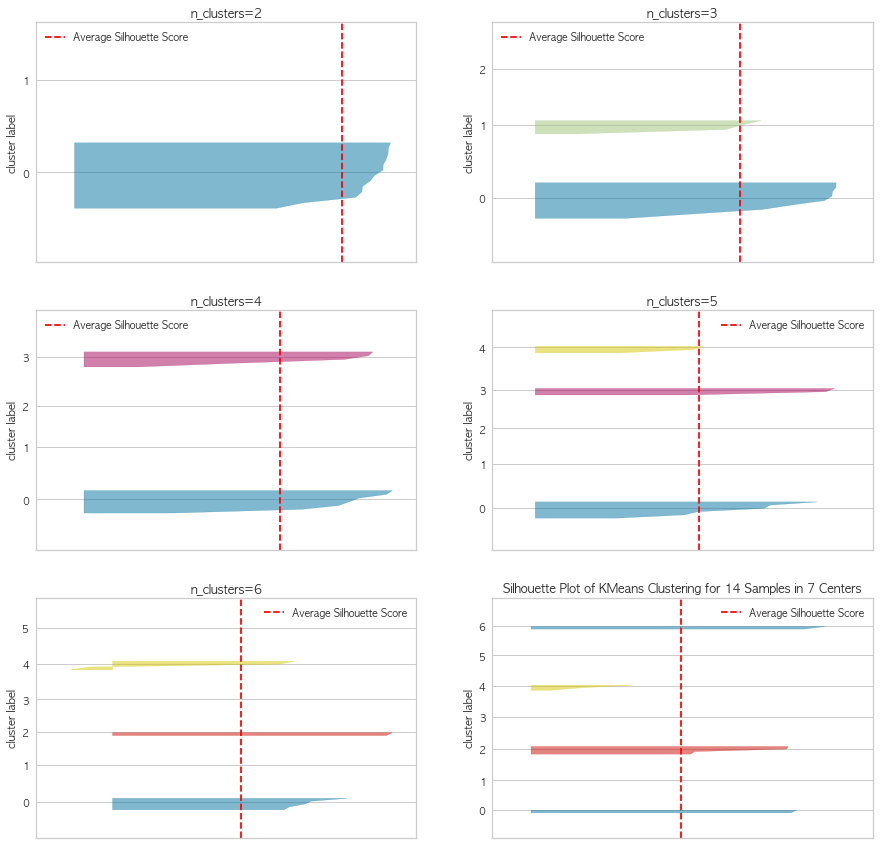

In [21]:
km.silhouette_visualizer(km.pca_df)

- 전체 데이터의 평균 실루엣 계수 값이 크다고 반드시 최적의 군집 개수로 군집화가 잘 됐다고 볼 수는 없습니다. 이를 보완해주기 위해 실루엣 계수를 시각화한 자료를 참고해야 합니다.
- 색상이 들어간 막대가 각 군집을 의미하고, 빨간색 점선은 위에서 구한 해당 군집 개수의 실루엣 계수입니다.
- 이 군집들이 빨간 점선인 평균 실루엣 계수를 많이 넘을수록 균일하게 잘 분류된 것을 의미합니다.

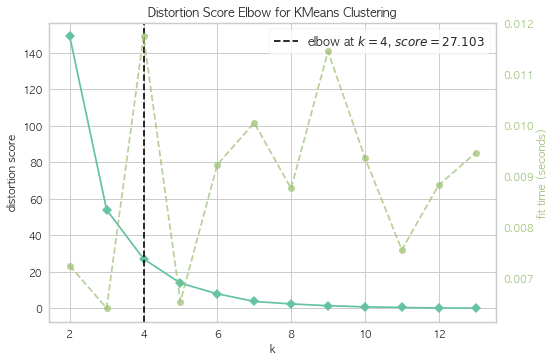

In [22]:
km.kelbow_visualizer(km.pca_df)

- 엘보우 방법은 오차들의 거리(__SSE__)를 이용하여 최적의 군집 개수를 정합니다. 위에서 검은색 점선으로 표시된 점이 최적의 군집 개수입니다.
- 위의 결과를 종합해서, __k=4__ 를 선택했습니다.

### 4.2.2. K-Means 시각화(PCA)
- 문서는 대체로 3차원보다 훨씬 높은 __고차원__ 의 데이터입니다. 이 고차원의 데이터를 그대로 K-means를 실행해도 문제가 없지만, 사람은 3차원까지의 데이터만 인식할 수 있으므로 고차원 데이터를 2차원 혹은 3차원으로 차원 축소를 해줘야 합니다.
- 차원을 축소하는 방법에는 일반적으로 많이 사용하는 분산을 이용한 __PCA__ 방법을 이용했습니다.
- 아래의 결과는 위에서 평가한 군집 개수를 이용하여 __PCA__ 를 군집화한 결과를 시각화한 결과입니다.
- 또한, 문서의 단어를 __BOW__ 방식으로 변환하였으므로, 특정 단어를 많이 사용한 후보끼리 묶였을 가능성이 높습니다.
---

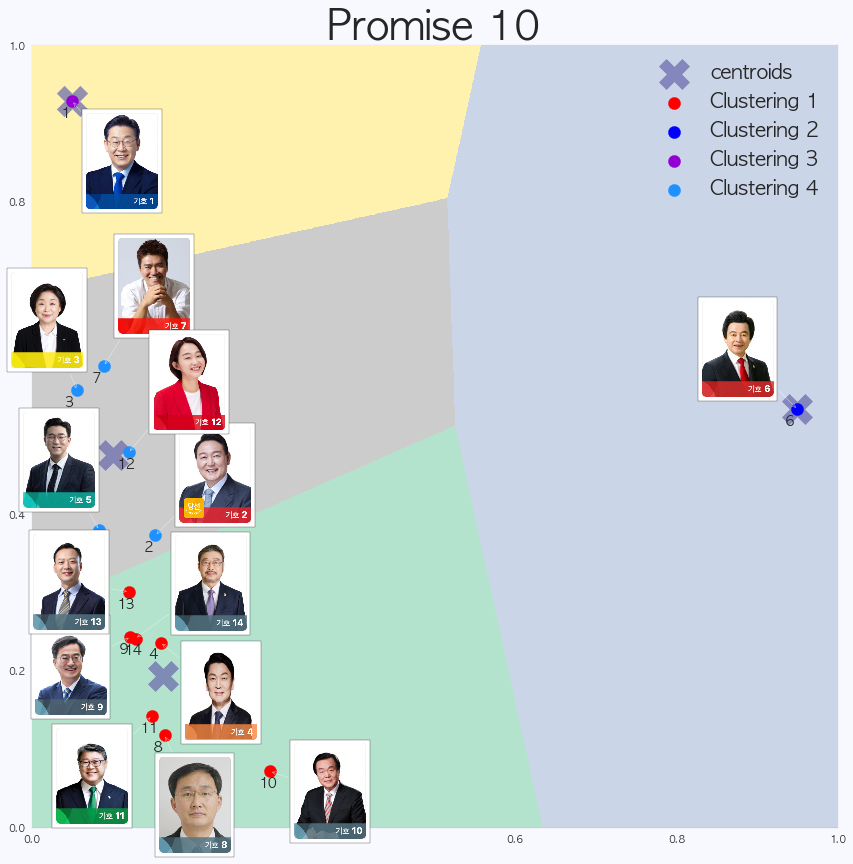

In [23]:
km1.PCA_show()

### 4.2.3. K 평균의 군집 갯수 평가 지표(UAMP)
- 여기서 제공하는 __UMAP__ 시각화는 후보의 공약 제목 문서를 위치 벡터값으로 변환하는 __Doc2Vec__ 방식을 적용했습니다.
- 퍼지 이론과 위상수학을 이용하여 고차원 데이터에 적합한 __UMAP__ 방법을 적용했습니다.
- 아래는 __PCA__ 와 동일하게 군집 개수를 평가한 지표 결과입니다.
---

In [24]:
km.sil_score(km.clusterable_embedding)

n_clusters=2, sihouette score=0.3926
n_clusters=3, sihouette score=0.3497
n_clusters=4, sihouette score=0.3589
n_clusters=5, sihouette score=0.2403
n_clusters=6, sihouette score=0.2483
n_clusters=7, sihouette score=0.1989
n_clusters=8, sihouette score=0.2075
n_clusters=9, sihouette score=0.1744
n_clusters=10, sihouette score=0.1424
n_clusters=11, sihouette score=0.0839
n_clusters=12, sihouette score=0.0752
n_clusters=13, sihouette score=0.0417


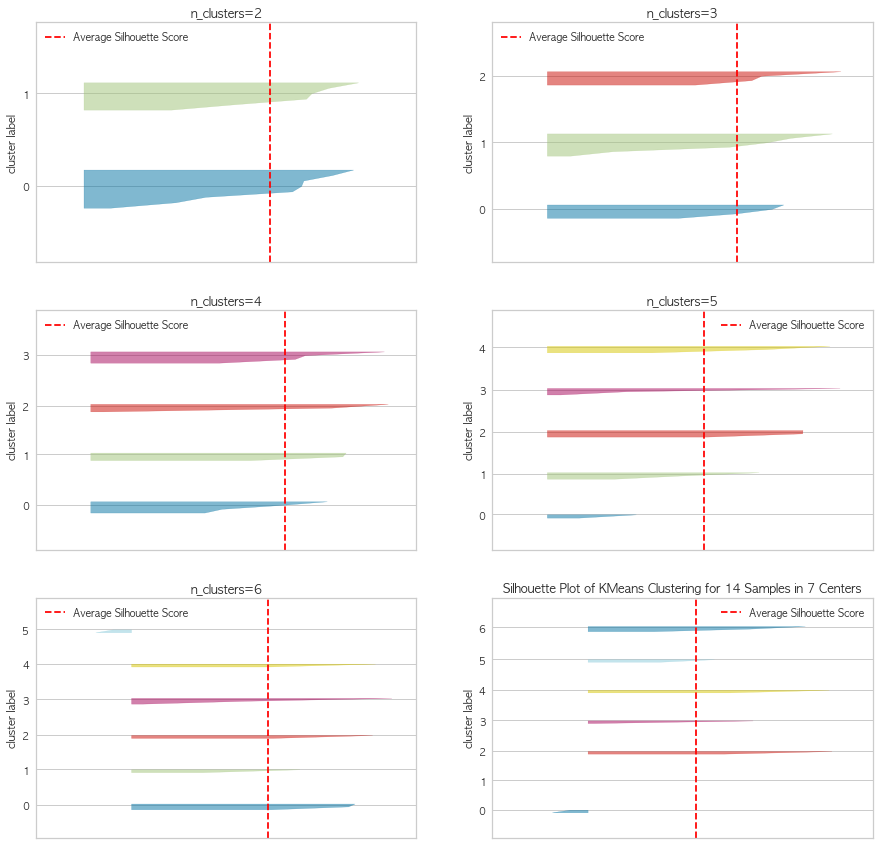

In [25]:
km.silhouette_visualizer(km.clusterable_embedding)

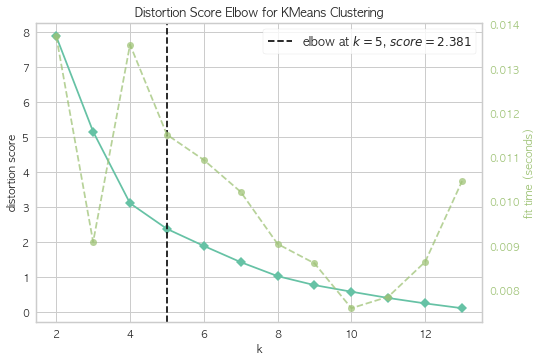

In [26]:
km.kelbow_visualizer(km.clusterable_embedding)

- 위의 결과는 UMAP을 각각 실루엣 계수와 엘보우 방법으로 평가한 결과로서 대략 __k = 4 or 5__ 일 때 결과가 좋게 나옵니다.
- 밑에서는 실루엣 시각화를 참고하여 __k = 4__ 일 때의 결과만 제공합니다.

### 4.2.4. K-Means 시각화(UMAP)
- 아래는 UMAP을 K-Means로 분류하여 시각화한 결과입니다.
- UMAP은 문서의 위치가 확률적으로 가장 가까운 후보끼리 군집화된 결과를 제공합니다.
---

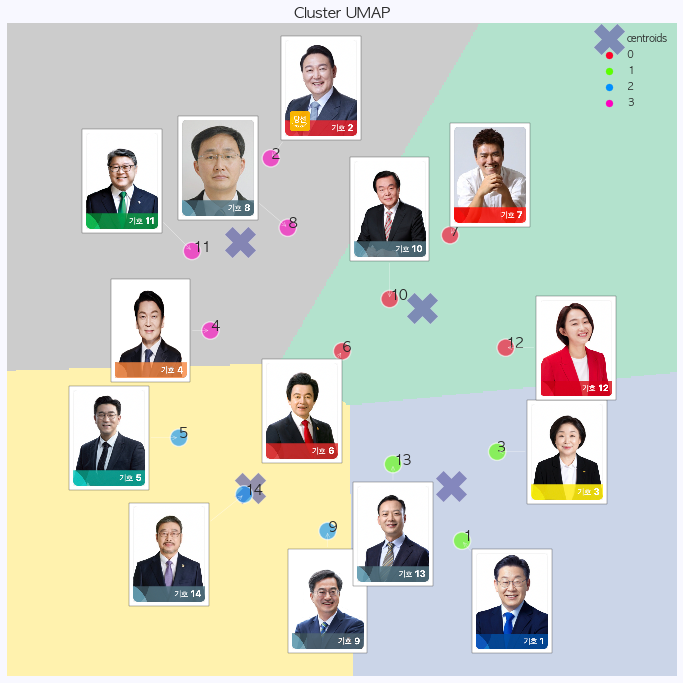

In [27]:
km.UMAP_show()

# 5. 후보추천

## 5.1. 지도학습 모델
- 클래스 설명
    - 단어 수 기반 지도학습을 이용한 후보 추천 클래스입니다.
    - __pred__ 함수에서 사용자가 문장이나 키워드를 입력하면 적합한 공약집을 추천합니다.


- 주요 라이브러리 : tensorflow, sklearn
---

### 5.1.1 Model Training

In [28]:
from tensorflow import random
class ML():
    def __init__(self):
        # self.clear_sentences,self.top10 = self.make_clear_sentences()
        pass
    
    def vetorize_seq(self,seqs, dim=10000):
        results = np.zeros((len(seqs), dim))
        for i, seq in enumerate(seqs):
            try:
                results[i, seq] += 1
            except:
                pass
            # print()
        return results

    def setting_data(self,list, dim, word_idx):
        for i in list:
            for j in range(len(i)):
                try:
                    i[j] = word_idx[i[j]]
                except:
                    i[j] = 0
        for i in list:
            for j in range(len(i)):
                if i[j] > dim:
                    i[j] = 0
        return self.vetorize_seq(list, dim)

    def preprocessing_ml_data(self,label_con,word_idx,dim):
        # dim = len(word_idx) 3900-
        train_data = []
        train_label = []
        for i in range(1, label_con + 1):
            temp_data = pre.lines_token[i - 1]
            temp_label = [i - 1] * len(temp_data)
            train_data.extend(temp_data)
            train_label.extend(temp_label)
        train_data = self.setting_data(train_data, dim, word_idx)
        train_label = np.array(train_label)
        return train_data, train_label

    def ml(self,label_con, train_data, train_label):
        
        random.set_seed(50)

        model = models.Sequential()
        model.add(layers.Dense(300, activation='relu'))
        model.add(layers.Dense(50, activation='relu'))

        model.add(layers.Dense(label_con, activation='softmax'))

        opt = optimizers.Adam(learning_rate=0.01)
        loss = losses.sparse_categorical_crossentropy
        model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

        model.fit(train_data, train_label, epochs=5, batch_size=50) #
        return model

    def show_similar_candidate(self,target_string,model,dim):
        target = model.predict(self.setting_data([okt.nouns(target_string)], dim, pre.word_idx))
        target = target.squeeze()
        idx = []
        acc = []
        for i in range(len(target)):
            if target[i] > 0.10:
                idx.append(i+1)
                acc.append(round(target[i] * 100, 2))
        return idx,acc

    def tf_idf_score(self):

        tf_sentences = pre.tf_sentences
        stopwords = pre.stopwords
        t_vec = TfidfVectorizer(max_features=3000, stop_words=stopwords)
        tdm = t_vec.fit_transform(tf_sentences)
        t_vec.get_feature_names_out()
        tf_rank = pd.DataFrame({
            '단어': t_vec.get_feature_names_out(),
            'tf-idf': tdm.sum(axis=0).flat
        })

        return tf_rank.sort_values(by='tf-idf',ascending=False)

    def pred(self):
        target_string = input('원하는 키워드를 적어 주세요. 카워드를 기반한 공약집이 추천 됩니다.')
        key = okt.nouns(target_string)
        idx, acc = mlc.show_similar_candidate(target_string, model, dim)
        candidate_dict = {idx[i]: acc[i] for i in range(len(idx))}

        for i in key:
            if i not in pre.word_idx.keys():
                key.pop(key.index(i))

        if not key:
            print('적용된 키워드가 없으므로 다시 검색해 주세요.')
        else:
            print(f'적용된 키워드: {key}')
            for i in idx:
                x = 0
                cnt = 0
                print()
                for j in range(1, 11):
                    if x == 0:
                        print(f'기호{i}번, {candidate_dict[i]}%')
                        x += 1


pre = PreprocessData(stopwords_path, pdf_path)
mlc = ML()
print('ML class load.')

ML class load.


- 학습 데이터는 공약집 각 후보자의 전체문장이고 각 문장을 후보자 번호로 레이블 했습니다.
- 입력 파라미터로 후보자 레이블 수에 대한 label_con 그리고 단어 벡터 길이 dim 값으로 dimension을 제한할 수 있습니다. 
- 데이터셋을 섞은 후 80% 분량은 훈련하였고 20% 분량으로 확인 절차를 진행했습니다.

In [29]:
label_con = 4
dim = 1500 # vector dimension
word_idx = pre.word_idx

# ML
train_data, train_label = mlc.preprocessing_ml_data(label_con, word_idx,dim=dim)
X_train, X_val, y_train, y_val = train_test_split(train_data,train_label, test_size=0.2,shuffle=True)
model = mlc.ml(label_con,train_data,train_label)

pred = model.predict(X_val)
pred = [np.argmax(i) for i in pred]
accuracy_score(pred,y_val) 

Metal device set to: Apple M1
Epoch 1/5


2022-04-12 00:37:24.238562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 00:37:24.239775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-12 00:37:24.410757: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/29 [>.............................] - ETA: 10s - loss: 1.4084 - accuracy: 0.2000

2022-04-12 00:37:24.664629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 1s 9ms/step - loss: 1.2334 - accuracy: 0.4341
Epoch 2/5
29/29 [==============================] - 0s 6ms/step - loss: 0.5218 - accuracy: 0.8004
Epoch 3/5
29/29 [==============================] - 0s 8ms/step - loss: 0.2259 - accuracy: 0.9163
Epoch 4/5
29/29 [==============================] - 0s 8ms/step - loss: 0.0910 - accuracy: 0.9574
Epoch 5/5
29/29 [==============================] - 0s 6ms/step - loss: 0.0578 - accuracy: 0.9763


2022-04-12 00:37:25.928213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.9581881533101045

### 5.1.2. Prediction

- 학습이 끝난 후, 클래스 내부에 있는 pred 메써드를 이용해서 사용자에게 입력받고 공약집을 리턴 합니다.
- 예측 단어 선택 보조지표로 __tf-idf__ 값을 확인할 수 있고, 예제에서는 임의로 상위 10개만 확인했습니다.
- 적용된 키워드와 매치되는 공약을 추천하게 됩니다.
- 문장을 입력했을 때, 매치되지않은 단어는 빠지게 됩니다.
---

In [30]:
tf_score = mlc.tf_idf_score()[:10]
tf_score

,단어,tf-idf
2933,확대,1.362935
2386,청년,1.261176
605,도입,1.151544
270,국가,1.130771
2132,주택,1.096497
2683,폐지,1.049186
1056,보장,1.031533
280,국민,1.024055
2011,제도,1.015810
2232,지원,1.014507


In [31]:
mlc.pred()

원하는 키워드를 적어 주세요. 카워드를 기반한 공약집이 추천 됩니다.도입
적용된 키워드: ['도입']

기호3번, 17.7%

기호4번, 69.89%


- 일반적으로 공약집에서 쓰이는 키워드를 사용할 경우 (tf-idf 값이 비교적 큰 경우), 확률이 퍼지게 됩니다.

In [32]:
mlc.pred()

원하는 키워드를 적어 주세요. 카워드를 기반한 공약집이 추천 됩니다.인공 지능
적용된 키워드: ['인공', '지능']

기호4번, 99.41%


- 후보 4번의 공약집을 검토한 결과, `인공지능을 이용한 차세대 불공정행위 감시시스템 구축` 을 발견할 수 있었습니다.
- 추가로 여러 가지 벡터화 기법을 적용해볼 수 있습니다.

## 5.2. 사용자의 관심사가 포함된 K-means 시각화

- 클래스 설명

    - 사용자가 관심이 있는 키워드를 이용해서 사용자의 관심사와 가장 비슷한 집단을 추천해줍니다.
    - 시각화 그래프에서 __USER__ 라는 빨간색 이름과 함께 추천 그룹과 같이 묶이게 됩니다.
    
    
- 주요 라이브러리 : umap, matplotlib
___

- 사용자의 관심사를 입력해줍니다.

In [33]:
top10_token_user = pre_user.top10_token
group_num = 4
km_ur = User_Kmeans(top10_token_user, image_path, n = group_num)

저는 부동산과 경제에 관심이 많습니다.


- 만약 다른 관심사를 입력해보고 싶다면 아래의 코드를 실행시켜 값을 입력하면 됩니다.

In [34]:
km_ur.change_userinput()

저는 취업을 준비하고 있는 학생입니다. 학생들이 일자리를 구할 수 있도록 다양한 교육 기회와 지원 정책에 관심이 많습니다.


USER의 관심사를 포함하는 후보군은 후보 2,8,11이 포함된 그룹 2 입니다.


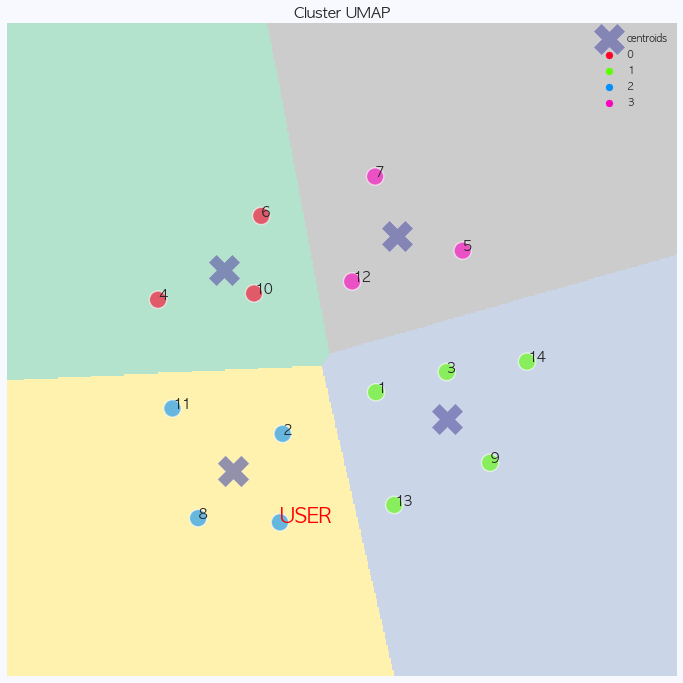

In [35]:
km_ur.UMAP_show()

## 5.3. 코사인 유사도

- 클래스 설명
    - 유사도를 이용한 후보자들의 정책 공약 추천 클래스입니다.
    - 사용자의 관심사와 관련 있는 정책 공약을 __코사인 유사도__를 활용하여 계산합니다. 
    - 정책 공약 제목만 사용하였습니다. 따라서, 정책 공약의 상세 내용이 반영되지 않아 결과가 예상과 다를 수 있습니다.


- 주요 라이브러리 : Word2Vec, cosine_similarity
---

In [36]:
class SearchPromise(): 
    def __init__(self):
        self.df_reshaped = cp.df[['정책 공약']]
        
        self.word_dict = self.word_vectorized()  
        
        self.df_reshaped_tokens = cp.df_tokens
        self.df_reshaped_vector = self.promise_vectorized()
    
    def dict_promise(self):
        dict_df = {value: f'기호 {index // 10 + 1}번' for index, value in zip(self.df_reshaped.index, self.df_reshaped['정책 공약'].values)}
        
        return dict_df
    
    def word_vectorized(self):
        tokens = []
        for text in self.df_reshaped.values.tolist():
            text = okt.nouns(str(text))
            token = [word for word in text if word in pre.word_idx]
            tokens.append(token)

        model = Word2Vec(tokens, min_count=1, window=3, workers=3, seed=1)

        word_dict = {}
        for vocab in model.wv.index_to_key:
            word_dict[vocab] = model.wv[vocab]
            
        return word_dict
    
    def promise_vectorized(self):
        dict_vector = {}
        df_reshaped_vector = self.df_reshaped.copy()
        for idx in df_reshaped_vector.index:
            list_vector = []
            for word in self.df_reshaped_tokens['정책 공약_tokens'][idx].split():
                if word in self.word_dict.keys():
                    list_vector.append(self.word_dict[word])
            dict_vector[df_reshaped_vector['정책 공약'][idx]] = np.sum(list_vector, axis=0).tolist()
            
        df_reshaped_vector['vector'] = df_reshaped_vector['정책 공약'].map(dict_vector)
        
        return df_reshaped_vector
    
    def user_input_to_vector(self):
        user_input = input('관심사를 입력하세요: ')
        tokenized_input = okt.nouns(user_input)
        
        list_vector = []

        for word in tokenized_input:
            if word in self.word_dict.keys():
                list_vector.append(self.word_dict[word])
        if len(list_vector) != 0:
            user_vector = (np.sum(list_vector, axis=0) / len(list_vector)).tolist()
        else:
            user_vector = 0
            
        return user_vector
    
    def find_similar_promise(self):
        user_vector = self.user_input_to_vector()
        if user_vector == 0:
            result = 0
        else:
            similarity = {}

            for idx in self.df_reshaped_vector.index:
                sim = cosine_similarity(np.array(user_vector).reshape(1, -1), 
                                        np.array([float(i) if i != '.' else float('0.0') for i in str(self.df_reshaped_vector.loc[idx, 'vector'])[1:-1].split(', ')]).reshape(1, -1))
                similarity[self.df_reshaped_vector['정책 공약'][idx]] = float(sim)
            similarity = {key: value for key, value in sorted(similarity.items(), key=lambda item: item[1], reverse=True)}
            rating = [str(key) for key, value in sorted(similarity.items(), key=lambda item: item[1], reverse=True)]
            top = rating[:3]
            result = {}

            for i in top:
                result[i] = str(abs(round(similarity[i]*100, 2))) + '%'
            
        return result
    
    def show_similar_promise(self):
        result = self.find_similar_promise()
        dict_df = self.dict_promise()
        if result == 0:
            print('관련 정책 공약이 존재하지 않습니다.')
        else:
            for i in result.keys():
                print(f'[{dict_df[i]}] {i} : {result[i]}')
                
sp = SearchPromise()
print('SearchPromise class load.')

SearchPromise class load.


### 5.3.1. 정책 공약 벡터화
- __Word2Vec__을 활용하여 후보자들의 정책 공약을 벡터로 변환합니다.
---

In [37]:
sp.df_reshaped_vector

,정책 공약,vector
0,코로나 팬데믹 완전극복과 피해소상공인에 대한 완전한 지원,"[0.0012157089076936245, 0.0008922452107071877,..."
1,"수출 1조 달러, 국민소득 5만 달러 달성, 주가지수 5000으로 세계5강 달성","[0.035784557461738586, 0.028226127848029137, -..."
2,"경제적 기본권 보장, 여성안심 평등사회, ‘청년기회국가' 건설","[-0.026466162875294685, 0.015330719761550426, ..."
3,"311만호 주택공급으로 내집마련•주거안정 실현, 함께 잘 사는 균형발전","[-0.010281102731823921, -0.007536951918154955,..."
4,"어르신, 환자, 장애인, 아동, 영•유아 돌봄 국가책임제, 국민안심국가 실현","[0.008476915769279003, 0.004498220980167389, 0..."
...,...,...
135,청와대 참모의 전문화,"[0.003724330570548773, 0.003927195444703102, 0..."
136,공정한 공기업 대표 인선,"[0.013669520616531372, 0.010402832180261612, -..."
137,"국민주거권 보장, 주택부(가칭) 신설","[-0.002753813285380602, 0.0012154625728726387,..."
138,법률개정위원회 구성,"[0.0010982782114297152, 0.004650736227631569, ..."


### 5.3.2. Prediction
- 클래스 내부에서 입력받은 사용자의 관심사를 입력받아 벡터로 변환합니다.
- 코사인 유사도를 활용하여 사용자의 관심사와 각 정책 공약의 거리를 비교한 다음, 가장 가까운 상위 3개의 정책 공약을 출력합니다.
---

In [38]:
sp.show_similar_promise()

관심사를 입력하세요: 차별과 폭력 없는 세상을 만들어 주세요!
[기호 12번] 모두가 차별없이 함께사는 세상 무상교육•무상의료•무상돌봄 시대 : 53.54%
[기호 7번] 차별금지법 제정으로 차별과 배제 없는 평등사회 : 24.04%
[기호 3번] 부동산 불평등 해소•투기 근절 기후위기•차별 해소를 위한 조세 개혁 : 24.0%


# Reference

1. [파이낸셜 뉴스](https://www.fnnews.com/election2022) : 후보자 비교 프론트 서비스

2. [더불어민주당 공약자료실](https://theminjoo.kr/board/lists/election)

3. [국민의힘 공약자료실](https://www.peoplepowerparty.kr/renewal/policy/data_pledge.do)

4. [정의당 공약자료실](https://www.justice21.org/newhome/board/board.html?bbs_code=JS56&num=147825)

5. [국민의당 공약자료실](https://peopleparty.kr/policy_dataroom)

6. [umap](https://www.sciencedirect.com/science/article/pii/S0010482521000585)

7. [LDA](https://wikidocs.net/30708)

pca와 umap 이해를 돕는 블로그
- https://velog.io/@stella_y/차원-축소-알고리즘을-비교해보자-PCA-T-sne-UMAP